In [4]:
# data science
import pandas as pd
import numpy as np
from sklearn import tree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# utils
import os
import pygraphviz as pgv
from PIL import Image
from time import process_time
from datetime import datetime

# metrics and reports
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, confusion_matrix

# normalize
from sklearn.preprocessing import Normalizer, MinMaxScaler

# resampling and folds
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# models and cv
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

# Informations
____

### Métricas de acurácia para DecisionTreeClassifier

- **Acurácia:** indica uma performance geral do modelo. Dentre todas as classificações, quantas o modelo classificou corretamente;
  - Boa indicação geral de como o modelo performou
  - Pode haver situações em que ela é enganosa
  - Você estaria validando como ótimo um modelo que falha
- **Precisão:** dentre todas as classificações de classe Positivo que o modelo fez, quantas estão corretas;
  - Falsos Positivos são considerados mais prejudiciais que os Falsos Negativos
- **Recall/Revocação/Sensibilidade:** dentre todas as situações de classe Positivo como valor esperado, quantas estão corretas;
  - Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos
- **F1-Score:** média harmônica entre precisão e recall.
  - Observar somente 1 métrica ao invés de duas (precisão e recall)
  - Está muito mais próxima dos menores valores do que uma média aritmética simples
  - F1-Score baixo, é um indicativo de que ou a precisão ou o recall está baixo
  
- **AUC-ROC** curve is one of the most commonly used metrics to evaluate the performance of machine learning algorithms particularly in the cases where we have imbalanced datasets.
- **F-Beta**
   - To give more weight to the Precision, we pick a Beta value in the interval 0 < Beta < 1
   - To give more weight to the Recall, we pick a Beta Value in the interval 1 < Beta < +∞

- **StratifiedKFold**
  - Pega a mesma proporção de cada classe 
  - É o padrão para uso no cv

### cross_val_predict

- cv: Determines the cross-validation splitting strategy
  - integer, to specify the number of folds in a (Stratified)KFold
  - (Stratified)KFold: The folds are made by preserving the percentage of samples for each class
  - https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py
  
  
- https://datascience.stackexchange.com/questions/36862/macro-or-micro-average-for-imbalanced-class-problems
- https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult
- https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
- For imbalanced class problems:
  - Use micro-averaging to weight your metric towards the largest one (soma tudo e cálcula a métrica)
  - Use macro-averaging to weight your metric towards the smallest one (cálcula cada métrica e faz a média)

## Variables

In [2]:
featuresColumns = ['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']
targetColumn = 'receipt_status'
class_names = ['sucess', 'fail']

In [3]:
dict = {}

## Functions

In [4]:
def plotRealPredictVersus(df, y_test, y_predict, class_names):
    '''
    plots
    '''
    

    # set up a figure twice as wide as it is tall
    fig = plt.figure(figsize=(16,16))
    # set colors 0 and 1
    color0 = 'red'
    color1 = 'blue'
    colors = np.array([color0, color1])
    print('\n{}: {}'.format(class_names[0], color0))
    print('{}: {}'.format(class_names[1], color1))
    
    #===============
    #  First subplot
    #===============
    # set up the axes for the first plot
    ax = fig.add_subplot(2, 2, 1, projection='3d')
    ax.scatter(df.gas, df.gas_price, df.value, c=colors[y_test], alpha=0.6, s=abs(y_test-2)**5+5)
    ax.set_xlabel('gas')
    ax.set_ylabel('gas_price')
    ax.set_zlabel('value')
    ax.set_title('y real')

    #===============
    # Second subplot
    #===============
    # set up the axes for the second plot
    ax = fig.add_subplot(2, 2, 2, projection='3d')
    ax.scatter(df.gas, df.gas_price, df.value, c=colors[y_predict], alpha=0.6, s=abs(y_predict-2)**5+5)
    ax.set_xlabel('gas')
    ax.set_ylabel('gas_price')
    ax.set_zlabel('value')
    ax.set_title('y predito')
    
    
    #===============
    # Third subplot
    #===============
    rightResultOfDifference = df[y_test == y_predict]
    rightResultsCVPredict = y_predict[y_test == y_predict]
    # set up the axes for the second plot
    ax = fig.add_subplot(2, 2, 3, projection='3d')
    ax.scatter(rightResultOfDifference.gas, rightResultOfDifference.gas_price, rightResultOfDifference.value, c=colors[rightResultsCVPredict], alpha=0.6, s=abs(rightResultsCVPredict-2)**5+5)
    ax.set_xlabel('gas')
    ax.set_ylabel('gas_price')
    ax.set_zlabel('value')
    ax.set_title('y right')
    
    #===============
    # Fourth subplot
    #===============
    wrongResultOfDifference = df[y_test != y_predict]
    wrongResultsCVPredict = y_test[y_test != y_predict] # y_predict trocado por y_test, para ter cor original
    # set up the axes for the second plot
    ax = fig.add_subplot(2, 2, 4, projection='3d')
    ax.scatter(wrongResultOfDifference.gas, wrongResultOfDifference.gas_price, wrongResultOfDifference.value, c=colors[wrongResultsCVPredict], alpha=0.6, s=abs(wrongResultsCVPredict-2)**5+5)
    ax.set_xlabel('gas')
    ax.set_ylabel('gas_price')
    ax.set_zlabel('value')
    ax.set_title('y wrong')

    plt.show()

In [5]:
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

def gridSearchDecisionTree(X, y):#df):
    start = process_time()

    #Running GridSearchCV using multiple evaluation metrics
    # Load the dataset
    #df = df
    #X = df[featuresColumns]
    #y = df[targetColumn]
    class_names = np.asarray(['success', 'fail'])

    # The scorers can be either be one of the predefined metric strings or a scorer
    # callable, like the one returned by make_scorer
    #scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
    scoring = {'AUC': 'roc_auc', 'Accuracy' : make_scorer(metrics.accuracy_score, average='macro')}#, 'Precion' : make_scorer(precision_score), 'Recall' : make_scorer(recall_score)}


    gridS_params = {#'max_depth': [None, 3, 4, 5],
                'min_samples_split': [.01, .05, .1, .2],
                'min_samples_leaf': [.01, .05, .1, .2],
                'min_impurity_decrease': [.01, .05, .1, .2]}
                #'max_leaf_nodes': [None, 5, 10, 15, 20, 50]}


    # Setting refit='AUC', refits an estimator on the whole dataset with the
    # parameter setting that has the best cross-validated AUC score.
    # That estimator is made available at ``gs.best_estimator_`` along with
    # parameters like ``gs.best_score_``, ``gs.best_params_`` and
    # ``gs.best_index_``
    gs = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'),
                        n_jobs=None, param_grid=gridS_params,# range(1, 20, 2)[2, 5, 10]
                       cv=10, return_train_score=True, scoring=make_scorer(metrics.recall_score, average='macro'))#, refit='AUC', scoring=scoring)

    #'class_weight': [None, 'balanced'],'min_impurity_decrease': [.01, .05,.1, .15, .2, .25, .3]}                              
    gs.fit(X, y)
    results = gs.cv_results_

    print ('best estimator ----------', gs.best_estimator_, '\n\n')
    #print ('cv results ----------', gs.cv_results_, '\n\n')
    print ('best score ----------', gs.best_score_, '\n\n')
    print ('best params ----------', gs.best_params_, '\n\n')
    print ('best index ----------', gs.best_index_, '\n\n')


    # get best decision tree
    decisionTreeToGraph(gs.best_estimator_, featuresColumns, class_names=class_names, saveFileName='bestGridSearchDecisionTreeTests')

    end = process_time() - start
    print('Time: ', end)
    
    return gs.best_estimator_

In [6]:
def decisionTreeToGraph(modelDt, columns, class_names, saveFileName):
    expModelo = tree.export_graphviz(modelDt, out_file=None, feature_names=columns, class_names=class_names, filled=True, rounded=True, special_characters=True, max_depth=2) 
    grafo = pgv.AGraph(expModelo)
    
    monthDay = datetime.now().strftime('%y') + datetime.now().strftime('%m') + datetime.now().strftime('%d')
    saveFileName = saveFileName + '_' + monthDay
    
    if(saveFileName not in dict):
        dict[saveFileName]=-1 
    dict[saveFileName]+=1
    saveFileName = (saveFileName + '_' + str(dict[saveFileName]))
    print(saveFileName)
    
    
    #path = '../decision-tree/' + monthDay +'/'
    #os.mkdir(path)
    details = open('../decision-tree/details.txt','a')
    details.write(saveFileName + '\n')
    details.write(str(modelDt.get_params(deep=False)) + '\n\n')
    details.close()
    
    pathFile = '../decision-tree/' + saveFileName
    
    formatImg = 'png'
    grafo.draw(pathFile + '.' + formatImg, formatImg, 'dot')
    
    formatImg = 'svg'
    grafo.draw(pathFile + '.' + formatImg, formatImg, 'dot')
    
    #formatImg = 'pdf'
    #grafo.draw(pathFile + '.' + formatImg, formatImg, 'dot')

    Image.open(pathFile + '.png')
    # imprime o modelo da arvore
    #printDecisions(modelo, X.columns, ['unconfirmed', 'confirmed'])

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
    cmNorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   

    
    fig, ax = plt.subplots()
    im = ax.imshow(cmNorm, interpolation='nearest', cmap=cmap)
    #print(im)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cmNorm.shape[1]),
           yticks=np.arange(cmNorm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion matrix - '+title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    
    # Loop over data dimensions and create text annotations.
    thresh = cmNorm.max() / 2.
    for i in range(cmNorm.shape[0]):
        for j in range(cmNorm.shape[1]):
            txt = format(cm[i, j], 'd') + '\n' + format(cmNorm[i, j], '.2f')
            ax.text(j, i, txt,
                    ha="center", va="center",
                    color="white" if cmNorm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()
    #return ax




In [8]:
def plot_roc_curve(X_test, y_test, y_predict, model, info):
    # Step 6: Predict probabilities for the test data.
    probs = model.predict_proba(X_test)#[:,1]
    # Step 7: Keep Probabilities of the positive class only.
    probs = probs[:, 1]
    # Step 8: Compute the AUC Score.
    auc = metrics.roc_auc_score(y_test, probs)
    print('\n----ROC Curve----\nAUC: %.2f' % auc)
    # Step 9: Get the ROC Curve.
    # false_positive_rate, true_positive_rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, probs)
    print(metrics.auc(fpr, tpr),'\n-----------------\n')
    # Step 10: Plot ROC Curve using our defined function
    
    plt.plot(fpr, tpr, color='red', label='ROC') #orange
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - ' + info)
    plt.legend()
    plt.show()

In [9]:
def valueMetrics(y_test, y_predict):

    print('-------')
    print('Metrics')
    print('-------')

    print('Acurácia:', metrics.accuracy_score(y_test, y_predict))
    
    print('\n------------')
    print('Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.')
    print('Micro: Calcule métricas para cada classe e encontre sua média não ponderada.')
    print('------------')
    
    print('\nPrecisão normal:', metrics.precision_score(y_test, y_predict))
    print('Precisão macro:', metrics.precision_score(y_test, y_predict, average='macro'))
    print('Precisão micro:', metrics.precision_score(y_test, y_predict, average='micro'))
    
    print('\nRecall normal:', metrics.recall_score(y_test, y_predict))
    print('\nRecall macro:', metrics.recall_score(y_test, y_predict, average='macro'))
    print('Recall micro:', metrics.recall_score(y_test, y_predict, average='micro'))
    
    print('\nF1-Score normal:', metrics.f1_score(y_test, y_predict ))
    print('\nF1-Score macro:', metrics.f1_score(y_test, y_predict ,average='macro'))
    print('F1-Score micro:', metrics.f1_score(y_test, y_predict ,average='micro'))
    
    print('\nFbeta1 normal:', metrics.fbeta_score(y_test, y_predict, beta=1))
    print('\nFbeta1 macro:', metrics.fbeta_score(y_test, y_predict ,average='macro', beta=1))
    print('Fbeta1 micro:', metrics.fbeta_score(y_test, y_predict ,average='micro', beta=1))
    
    print('\nFbeta2 normal:', metrics.fbeta_score(y_test, y_predict ,beta=2))
    print('\nFbeta2 macro:', metrics.fbeta_score(y_test, y_predict ,average='macro', beta=2))
    print('Fbeta2 micro:', metrics.fbeta_score(y_test, y_predict ,average='micro', beta=2))
    
    print('\nFbeta200 normal:', metrics.fbeta_score(y_test, y_predict ,beta=200))
    print('\nFbeta200 macro:', metrics.fbeta_score(y_test, y_predict ,average='macro', beta=200))
    print('Fbeta200 micro:', metrics.fbeta_score(y_test, y_predict ,average='micro', beta=200))

    print('\nCálculo manual')
    tp = y_test[(y_test==1) & (y_predict==1)].count()
    tn = y_test[(y_test==0) & (y_predict==0)].count()
    fp = y_test[(y_test==0) & (y_predict==1)].count()
    fn = y_test[(y_test==1) & (y_predict==0)].count()
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    precision = tp/(tp+fp) 
    recall = tp/(tp+fn)
    #precision2 = tn/(tn+fn) 
    #recall2 = tn/(tn+fp)
    print('len:', len(y_test), 'tp=', tp, 'tn=', tn, 'fp=', fp, 'fn=', fn)
    print('Acurácia (tp+tn)/(tp+tn+fp+fn):', accuracy)
    print('Precisão tp/(tp+fp) :', precision)
    print('Recall tp/(tp+fn):', recall)
    #print('Precisão2 tn/(tn+fn):', precision2)
    #print('Recall2 tn/(tn+fp):', recall2)
    
    print('fbeta1-manual: ', (2*precision*recall)/(precision+recall))
    print('fbeta2-manual: ', (5*precision*recall)/(4*precision+recall))
    print('fbeta200-manual: ', (40001*precision*recall)/(40000*precision+recall))
    
    
    #print('\nOthers')
    #print('Jaccard:', metrics.jaccard_score(y_test, y_predict, average='micro')) # interceção/união
    #print('Jaccard:', metrics.jaccard_score(y_test, y_predict, average='macro')) # interceção/união
    #print('Jaccard:', metrics.jaccard_score(y_test, y_predict, average=None)) # interceção/união
    #print('Hamming Loss:', metrics.hamming_loss(y_test, y_predict)) # porcentagem de diferentes

In [10]:
def analysis(X_test, y_test, y_predict, model, text):
    print(text, end='\n\n')
    plot_confusion_matrix(y_test, y_predict, classes=class_names, title=text) # Ethereum Matrix Confusion

    print(classification_report(y_test, y_predict))
    
    #valueMetrics(y_test, y_predict)

    if (type(model).__name__ is not 'LinearRegression'):
        plot_roc_curve(X_test, y_test, y_predict, model, text)

    acuracy = metrics.accuracy_score(y_test, y_predict)
    precision = metrics.precision_score(y_test, y_predict)
    recall= metrics.recall_score(y_test, y_predict)
    f_score = metrics.f1_score(y_test, y_predict)
    f_beta = metrics.fbeta_score(y_test, y_predict, beta=2)
    TP = len(y_test[(y_test==1) & (y_predict==1)]) #é falha 3%
    TN = len(y_test[(y_test==0) & (y_predict==0)]) #não é falha 97%
    ROC_auc_curve = metrics.roc_auc_score(y_test, y_predict)
    
    results_metrics = metrics_structure()
    results = [acuracy, precision, recall, f_score, f_beta, TP, TN, ROC_auc_curve]
    results_metrics = results_metrics.append(pd.DataFrame([results], index=[text], columns=results_metrics.columns))
    print(results_metrics)
    
    #return results_metrics

In [11]:
def metrics_structure():
    results = pd.DataFrame({'Acuracy':[],
                            'Precision':[],
                            'Recall':[],
                            'F1-score':[],
                            'F-beta':[],
                            'TP':[],
                            'TN':[],
                            'ROC Curve':[]}, )
    results.index.names = ['Algoritmos']
    return results

In [12]:
# Predição
def crossValidationPredict(df, balancing=False):
    X = df[featuresColumns]
    y = df[targetColumn]
    
    #arg = {'min_impurity_decrease':0.01, 'max_depth':4, 'min_samples_leaf':0.01, 'min_samples_split':0.01}
    
    if(balancing): model = tree.DecisionTreeClassifier(class_weight='balanced')
    else: model = tree.DecisionTreeClassifier()
    
    #model.set_params(**arg)
    results = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
    #model.fit(X, y)
    #model.predict(X,y)
    
    return y, results, model

In [13]:
# Predição
def crossValidationPredict(df, nameOfPlot, balancing=False):
    X = df[['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']]
    y = df['receipt_status']

    class_names = np.asarray(['unconfirmed', 'confirmed'])
    
    if(balancing): model = tree.DecisionTreeClassifier(class_weight='balanced')
    else: model = tree.DecisionTreeClassifier(class_weight='balanced')
    results = cross_val_predict(model, X, y, cv=10)
    
    #Plot confusion matrix
    plot_confusion_matrix(y, results, classes=class_names, title=nameOfPlot)
    plot_confusion_matrix(y, results, classes=class_names, normalize=True, title=nameOfPlot)
    plt.show()
    
    
    return accuracy_score(y, results)

In [14]:
# score
def crossValidation(df, balancing=False):
    X = df[['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']]#df.drop('receipt_status', axis=1)
    y = df['receipt_status']

    if(balancing==True): model = tree.DecisionTreeClassifier(class_weight='balanced')
    else: model = tree.DecisionTreeClassifier()

    results = cross_validate(model, X, y,cv=10, return_train_score=True, return_estimator=True, n_jobs=-1)
    print('test_score: ', results['test_score'])
    #print('train_score: ', results['train_score'])
    #print(results['fit_time'])
    #print(results['score_time'])
    #print(results['estimator'])

In [15]:
def underSample(X, y, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    class_minority = 0
    class_majority = 1
    
    X_train = pd.concat([X_train, y_train], axis=1)
    
    if(len(X_train[X_train.iloc[:, -1] == class_majority]) < len(X_train[X_train.iloc[:, -1] == class_minority])):
        class_minority = 1
        class_majority = 0
    
    df_majority = X_train[X_train.iloc[:, -1]==class_majority]
    df_minority = X_train[X_train.iloc[:, -1]==class_minority]
    
    len_minority = len(df_minority)
    
    df_majority_undersampled = resample(df_majority, replace=False, n_samples=len_minority, random_state=random_state)
    undersampled = pd.concat([df_majority_undersampled, df_minority])
    
    X_train = undersampled.iloc[:, :-1] # remove ultima coluna
    y_train = undersampled.iloc[:, -1] # pega apenas ultima coluna
    
    return X_train, X_test, y_train, y_test

In [16]:
def overSample(X, y, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    class_minority = 0
    class_majority = 1
    
    X_train = pd.concat([X_train, y_train], axis=1)
    
    if(len(X_train[X_train.iloc[:, -1] == class_majority]) < len(X_train[X_train.iloc[:, -1] == class_minority])):
        class_minority = 1
        class_majority = 0
    
    df_majority = X_train[X_train.iloc[:, -1]==class_majority]
    df_minority = X_train[X_train.iloc[:, -1]==class_minority]
    
    len_majority = len(df_majority)
    
    df_minority_oversampled = resample(df_minority, replace=True, n_samples=len_majority, random_state=random_state)
    oversampled = pd.concat([df_minority_oversampled, df_majority])
    
    X_train = oversampled.iloc[:, :-1] # remove ultima coluna
    y_train = oversampled.iloc[:, -1] # pega apenas ultima coluna
    
    return X_train, X_test, y_train, y_test

In [17]:
def smoteSample(X, y, test_size, random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    sm = SMOTE(random_state = 2) # sampling_strategy='minority', ratio=1.0
    X_train, y_train = sm.fit_sample(X_train, y_train)
    return X_train, X_test, y_train, y_test

In [92]:
def cv(X, y, model, name, balancer = None):

    results_cv = metrics_structure()
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    auc_media = 0
    
    skfold = StratifiedKFold(n_splits=10)

    for fold, (train_index, test_index) in enumerate(skfold.split(X, y), 1):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]  # Based on your code, you might need a ravel call here, but I would look into how you're generating your y
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]  # See comment on ravel and  y_train
        if balancer is not None:
            X_train, y_train = balancer.fit_sample(X_train, y_train)
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        print(f'For fold {fold}:')
        acuracy = metrics.accuracy_score(y_test, y_predict)
        precision = metrics.precision_score(y_test, y_predict)
        recall = metrics.recall_score(y_test, y_predict)
        f_score = metrics.f1_score(y_test, y_predict)
        f_beta = metrics.fbeta_score(y_test, y_predict, beta=2)
        ROC = metrics.roc_auc_score(y_test, y_predict)
        TP = len(y_test[(y_test==1) & (y_predict==1)])
        TN = len(y_test[(y_test==0) & (y_predict==0)])
        
        tp += y_test[(y_test==1) & (y_predict==1)].count()
        tn += y_test[(y_test==0) & (y_predict==0)].count()
        fp += y_test[(y_test==0) & (y_predict==1)].count()
        fn += y_test[(y_test==1) & (y_predict==0)].count()  
        
        auc_media += ROC
        
        result_fold = [acuracy, precision, recall, f_score, f_beta, TP, TN, ROC]
        results_cv = results_cv.append(pd.DataFrame([result_fold], index=[('Fold' + str(fold))], columns=results_cv.columns))
        
        if fold == 1:
            print('best fold', str(fold))
            bestROC = ROC
            bestModel = model
            analysis(X_test, y_test, y_predict, model, name)
        elif ROC > bestROC:
            print('best fold', str(fold))
            bestROC = ROC
            bestModel = model
            analysis(X_test, y_test, y_predict, model, name)
            
    acur = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp)
    reca = tp/(tp+fn)
    f1sc = (2*reca*prec)/(reca+prec)
    f2sc = (5*reca*prec)/((4*prec)+reca)
    
    auc_media /= 10

    results_metrics = metrics_structure()
    results = [acur, prec, reca, f1sc, f2sc, tp, tn, auc_media]
    results_metrics = results_metrics.append(pd.DataFrame([results], index=[name], columns=results_metrics.columns))
    
    print('acuracy', acur)
    print('precision', prec)
    print('recall', reca)
    print('f1-score', f1sc)
    print('f2-score', f2sc)    
    print('auc best', bestROC)
    print('auc media', auc_media)
    print('Tot:', len(y_test), ' 0:', len(y_test[y_test==0]), ' 1:', len(y_test[y_test==1]), sep='')
    
    return results_metrics, results_cv, bestModel

## Read Data

In [19]:
dfRead = pd.read_csv('../datasets/dataset_20190812.csv', usecols=['joined_pool', 'joined_chain', 'value', 'gas', 'gas_price', 'gas_offered', 'receipt_status'], dtype={'value':'float'})

## Prepare Data

In [20]:
# pass to datetime type
dfRead.joined_pool = pd.to_datetime(dfRead.joined_pool)
dfRead.joined_chain = pd.to_datetime(dfRead.joined_chain)

# sort values by [joined_chain, joined_pool]
dfRead = dfRead.sort_values(by=['joined_chain', 'joined_pool'])
dfRead = dfRead.reset_index(drop=True)

# create time_pending column with data type
dfRead['time_pending_date'] = dfRead.joined_chain - dfRead.joined_pool

# time_pending column date type (datetime64) => int
dfRead['time_pending'] = pd.to_timedelta(dfRead.time_pending_date).dt.total_seconds().astype(int)

# Take off the negatives
dfRead = dfRead[dfRead.time_pending > 0]

In [21]:
# Inverting
dfRead.receipt_status = 1 - dfRead.receipt_status

In [22]:
print(dfRead.joined_pool.min())
print(dfRead.joined_pool.max())

2019-04-15 18:13:09
2019-07-26 07:50:02


In [23]:
print('Total:', len(dfRead))
print('Confirmed:', len(dfRead[dfRead.receipt_status == 1]), '(%):', len(dfRead[dfRead.receipt_status == 1])/len(dfRead))
print('Unconfirmed:', len(dfRead[dfRead.receipt_status == 0]), '(%):', len(dfRead[dfRead.receipt_status == 0])/len(dfRead))

print('Smart Contracts: ', len(dfRead[dfRead.value == 0]), '(%)', len(dfRead[dfRead.value == 0])/len(dfRead))

Total: 2519711
Confirmed: 77542 (%): 0.030774164179939684
Unconfirmed: 2442169 (%): 0.9692258358200603
Smart Contracts:  1414241 (%) 0.5612711140285532


#### Normaliza dados

In [24]:
#dfRead[featuresColumns] = Normalizer().fit_transform(dfRead[featuresColumns])
dfRead[featuresColumns] = MinMaxScaler().fit_transform(dfRead[featuresColumns])

#### Sample Data

In [25]:
df = dfRead.sample(50000, random_state=2)

In [26]:
X = df[featuresColumns]
y = df[targetColumn]

# Análises
---

### Sem balanceamento

In [67]:
all_results = metrics_structure()

For fold 1:
best fold 1
Decision Tree



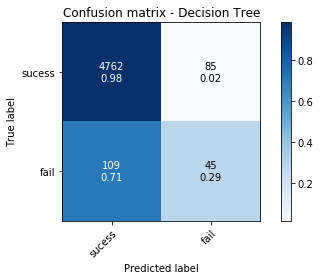

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4847
           1       0.35      0.29      0.32       154

    accuracy                           0.96      5001
   macro avg       0.66      0.64      0.65      5001
weighted avg       0.96      0.96      0.96      5001


----ROC Curve----
AUC: 0.64
0.6350721694233145 
-----------------



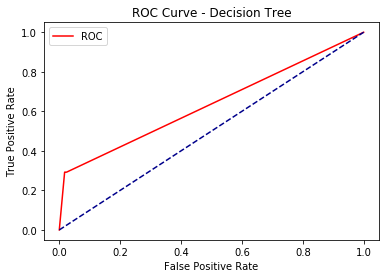

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Decision Tree  0.961208   0.346154  0.292208  0.316901  0.301609  45.0   

                   TN  ROC Curve  
Decision Tree  4762.0   0.637336  
For fold 2:
best fold 2
Decision Tree



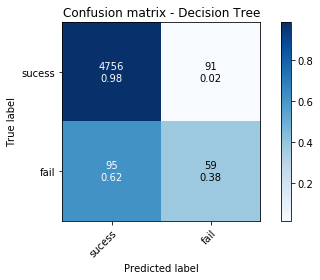

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4847
           1       0.39      0.38      0.39       154

    accuracy                           0.96      5001
   macro avg       0.69      0.68      0.68      5001
weighted avg       0.96      0.96      0.96      5001


----ROC Curve----
AUC: 0.68
0.6840219817319054 
-----------------



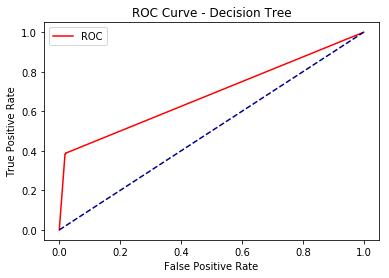

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Decision Tree  0.962807   0.393333  0.383117  0.388158  0.385117  59.0   

                   TN  ROC Curve  
Decision Tree  4756.0   0.682171  
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
acuracy 0.95868
precision 0.3279639175257732
recall 0.3322454308093995
f1-score 0.33009079118028534
f2-score 0.3313802083333334
auc best 0.6821711917131765
auc media 0.6553594911442666
Tot:4999 0:4846 1:153
none_200301_8


In [68]:
clf = tree.DecisionTreeClassifier()
result, results_folds, bestModel = cv(X, y, clf, 'Decision Tree')
all_results = all_results.append(result)
decisionTreeToGraph(bestModel, featuresColumns, class_names, 'none')

In [69]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Decision Tree,0.95868,0.327964,0.332245,0.330091,0.33138,509.0,47425.0,0.655359


In [70]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.961208,0.346154,0.292208,0.316901,0.301609,45.0,4762.0,0.637336
Fold2,0.962807,0.393333,0.383117,0.388158,0.385117,59.0,4756.0,0.682171
Fold3,0.953600,0.279330,0.326797,0.301205,0.316056,50.0,4718.0,0.650091
Fold4,0.959800,0.346154,0.352941,0.349515,0.351562,54.0,4745.0,0.665949
Fold5,0.955200,0.276730,0.287582,0.282051,0.285344,44.0,4732.0,0.631928
Fold6,0.960600,0.353333,0.346405,0.349835,0.347769,53.0,4750.0,0.663196
Fold7,0.958600,0.315068,0.300654,0.307692,0.303430,46.0,4747.0,0.640011
Fold8,0.957000,0.308642,0.326797,0.317460,0.322997,50.0,4735.0,0.651845
Fold9,0.959192,0.335484,0.339869,0.337662,0.338983,52.0,4743.0,0.659307
Fold10,0.958792,0.339394,0.366013,0.352201,0.360360,56.0,4737.0,0.671760


[0.04215759 0.21655652 0.20848175 0.17006118 0.36274297]


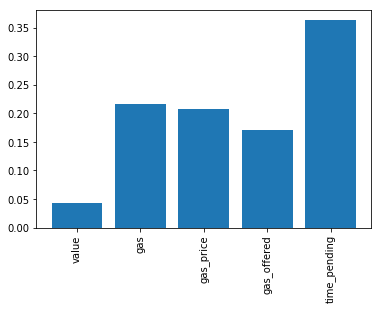

In [71]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Random Forest



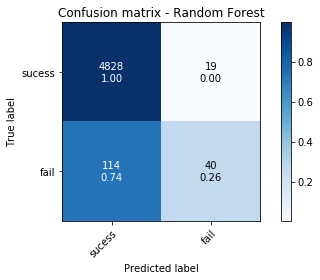

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4847
           1       0.68      0.26      0.38       154

    accuracy                           0.97      5001
   macro avg       0.83      0.63      0.68      5001
weighted avg       0.97      0.97      0.97      5001


----ROC Curve----
AUC: 0.80
0.8031571275846084 
-----------------



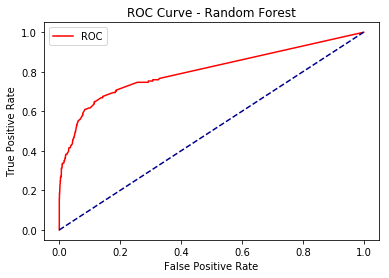

                Acuracy  Precision   Recall  F1-score    F-beta    TP      TN  \
Random Forest  0.973405   0.677966  0.25974  0.375587  0.296296  40.0  4828.0   

               ROC Curve  
Random Forest    0.62791  
For fold 2:
best fold 2
Random Forest



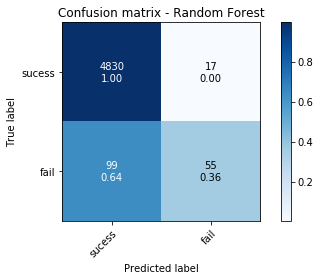

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4847
           1       0.76      0.36      0.49       154

    accuracy                           0.98      5001
   macro avg       0.87      0.68      0.74      5001
weighted avg       0.97      0.98      0.97      5001


----ROC Curve----
AUC: 0.82
0.819771367481291 
-----------------



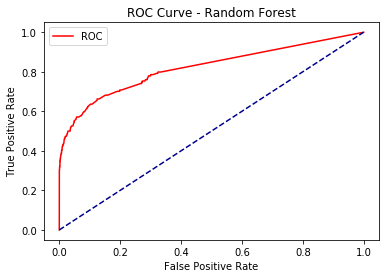

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Random Forest  0.976805   0.763889  0.357143  0.486726  0.399709  55.0   

                   TN  ROC Curve  
Random Forest  4830.0   0.676818  
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
best fold 10
Random Forest



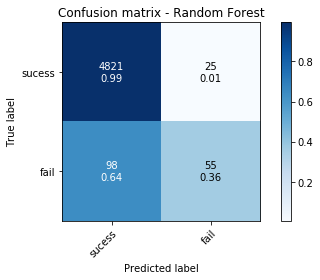

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4846
           1       0.69      0.36      0.47       153

    accuracy                           0.98      4999
   macro avg       0.83      0.68      0.73      4999
weighted avg       0.97      0.98      0.97      4999


----ROC Curve----
AUC: 0.83
0.8322570464421839 
-----------------



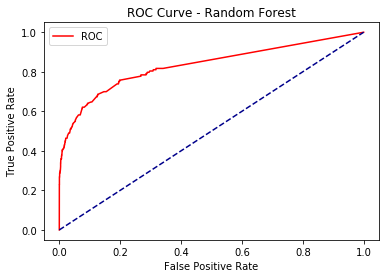

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Random Forest  0.975395     0.6875  0.359477  0.472103  0.397399  55.0   

                   TN  ROC Curve  
Random Forest  4821.0   0.677159  
acuracy 0.9729
precision 0.6159895150720839
recall 0.30678851174934724
f1-score 0.4095860566448801
f2-score 0.34102452474241757
auc best 0.677159115124933
auc media 0.650370574494137
Tot:4999 0:4846 1:153
rf_none_200301_0


In [72]:
clf = RandomForestClassifier(n_estimators=100, random_state=2)
result, results_folds, bestModel = cv(X, y, clf, 'Random Forest')
all_results = all_results.append(result)
decisionTreeToGraph(bestModel.estimators_[99], featuresColumns, class_names, 'rf_none')

In [73]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Random Forest,0.9729,0.61599,0.306789,0.409586,0.341025,470.0,48175.0,0.650371


In [74]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.973405,0.677966,0.259740,0.375587,0.296296,40.0,4828.0,0.627910
Fold2,0.976805,0.763889,0.357143,0.486726,0.399709,55.0,4830.0,0.676818
Fold3,0.971000,0.550000,0.287582,0.377682,0.317919,44.0,4811.0,0.640077
Fold4,0.972800,0.602410,0.326797,0.423729,0.359712,50.0,4814.0,0.659995
Fold5,0.970000,0.517647,0.287582,0.369748,0.315638,44.0,4806.0,0.639561
Fold6,0.974400,0.658228,0.339869,0.448276,0.376266,52.0,4820.0,0.667149
Fold7,0.971600,0.577465,0.267974,0.366071,0.300146,41.0,4817.0,0.630892
Fold8,0.970600,0.537500,0.281046,0.369099,0.310694,43.0,4810.0,0.636706
Fold9,0.972995,0.621622,0.300654,0.405286,0.335277,46.0,4818.0,0.647438
Fold10,0.975395,0.687500,0.359477,0.472103,0.397399,55.0,4821.0,0.677159


[0.03328383 0.21057495 0.2064996  0.19969016 0.34995145]


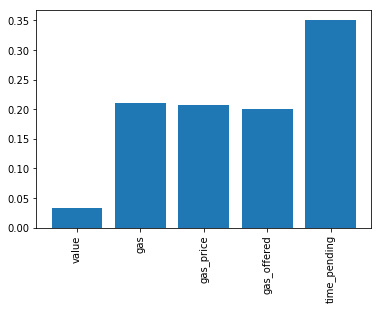

In [75]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Logistic Regression



/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


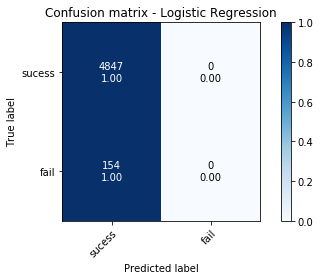

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4847
           1       0.00      0.00      0.00       154

    accuracy                           0.97      5001
   macro avg       0.48      0.50      0.49      5001
weighted avg       0.94      0.97      0.95      5001


----ROC Curve----
AUC: 0.74
0.7391966914867678 
-----------------



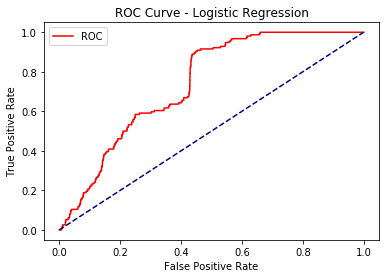

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                      Acuracy  Precision  Recall  F1-score  F-beta   TP  \
Logistic Regression  0.969206        0.0     0.0       0.0     0.0  0.0   

                         TN  ROC Curve  
Logistic Regression  4847.0        0.5  
For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 10:
acuracy 0.96936
precision nan
recall 0.0
f1-score nan
f2-score nan
auc best 0.5
auc media 0.5
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


In [76]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
result, results_folds, bestModel = cv(X, y, clf, 'Logistic Regression')
all_results = all_results.append(result)

In [77]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Logistic Regression,0.96936,NaN,0.0,NaN,NaN,0.0,48468.0,0.5


In [78]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold2,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold3,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold4,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold5,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold6,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold7,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold8,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold9,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5
Fold10,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5


For fold 1:
best fold 1
Linear SVM



/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


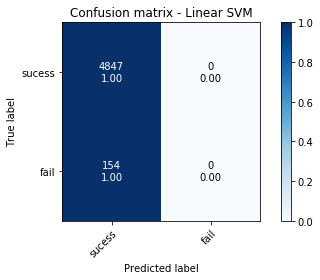

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4847
           1       0.00      0.00      0.00       154

    accuracy                           0.97      5001
   macro avg       0.48      0.50      0.49      5001
weighted avg       0.94      0.97      0.95      5001


----ROC Curve----
AUC: 0.61
0.6130562752700157 
-----------------



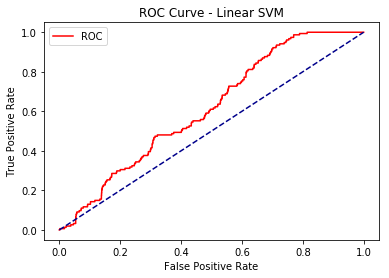

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


             Acuracy  Precision  Recall  F1-score  F-beta   TP      TN  \
Linear SVM  0.969206        0.0     0.0       0.0     0.0  0.0  4847.0   

            ROC Curve  
Linear SVM        0.5  
For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


For fold 10:
acuracy 0.96936
precision nan
recall 0.0
f1-score nan
f2-score nan
auc best 0.5
auc media 0.5
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


In [79]:
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
result, results_folds, bestModel = cv(X, y, clf, 'Linear SVM')
all_results = all_results.append(result)

In [80]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Linear SVM,0.96936,NaN,0.0,NaN,NaN,0.0,48468.0,0.5


In [81]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold2,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold3,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold4,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold5,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold6,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold7,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold8,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold9,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5
Fold10,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Gaussian SVM



/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


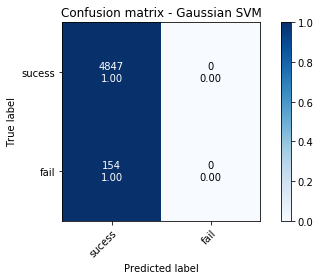

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4847
           1       0.00      0.00      0.00       154

    accuracy                           0.97      5001
   macro avg       0.48      0.50      0.49      5001
weighted avg       0.94      0.97      0.95      5001


----ROC Curve----
AUC: 0.52
0.520601175181328 
-----------------



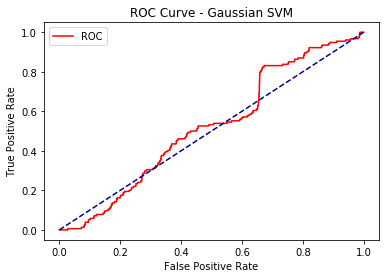

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


               Acuracy  Precision  Recall  F1-score  F-beta   TP      TN  \
Gaussian SVM  0.969206        0.0     0.0       0.0     0.0  0.0  4847.0   

              ROC Curve  
Gaussian SVM        0.5  
For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
acuracy 0.96936
precision nan
recall 0.0
f1-score nan
f2-score nan
auc best 0.5
auc media 0.5
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


In [82]:
clf = svm.SVC(kernel='rbf', probability=True) # Gaussian Kernel - gamma=0.1
result, results_folds, bestModel = cv(X, y, clf, 'Gaussian SVM')
all_results = all_results.append(result)

In [83]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Gaussian SVM,0.96936,NaN,0.0,NaN,NaN,0.0,48468.0,0.5


In [84]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold2,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold3,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold4,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold5,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold6,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold7,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold8,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold9,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5
Fold10,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Sigmoid SVM



/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


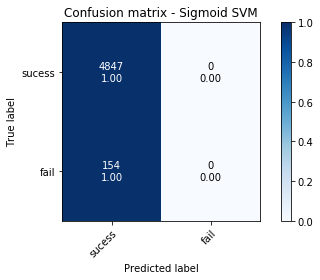

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4847
           1       0.00      0.00      0.00       154

    accuracy                           0.97      5001
   macro avg       0.48      0.50      0.49      5001
weighted avg       0.94      0.97      0.95      5001


----ROC Curve----
AUC: 0.69
0.6874053839702694 
-----------------



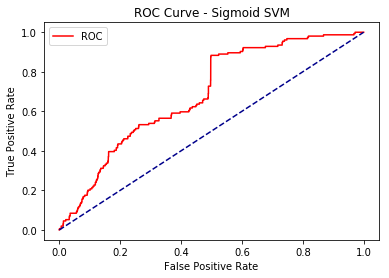

              Acuracy  Precision  Recall  F1-score  F-beta   TP      TN  \
Sigmoid SVM  0.969206        0.0     0.0       0.0     0.0  0.0  4847.0   

             ROC Curve  
Sigmoid SVM        0.5  

/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
acuracy 0.96936
precision nan
recall 0.0
f1-score nan
f2-score nan
auc best 0.5
auc media 0.5
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/viniman/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


In [85]:
clf = svm.SVC(kernel='sigmoid', probability=True) # Sigmoid Kernel
result, results_folds, bestModel = cv(X, y, clf, 'Sigmoid SVM')
all_results = all_results.append(result)

In [86]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Sigmoid SVM,0.96936,NaN,0.0,NaN,NaN,0.0,48468.0,0.5


In [87]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold2,0.969206,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold3,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold4,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold5,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold6,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold7,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold8,0.969400,0.0,0.0,0.0,0.0,0.0,4847.0,0.5
Fold9,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5
Fold10,0.969394,0.0,0.0,0.0,0.0,0.0,4846.0,0.5


## Resultados Gerais

In [88]:
all_results

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Decision Tree,0.95868,0.327964,0.332245,0.330091,0.331380,509.0,47425.0,0.655359
Random Forest,0.97290,0.615990,0.306789,0.409586,0.341025,470.0,48175.0,0.650371
Logistic Regression,0.96936,NaN,0.000000,NaN,NaN,0.0,48468.0,0.500000
Linear SVM,0.96936,NaN,0.000000,NaN,NaN,0.0,48468.0,0.500000
Gaussian SVM,0.96936,NaN,0.000000,NaN,NaN,0.0,48468.0,0.500000
Sigmoid SVM,0.96936,NaN,0.000000,NaN,NaN,0.0,48468.0,0.500000


In [89]:
print(all_results.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Acuracy &  Precision &    Recall &  F1-score &    F-beta &     TP &       TN &  ROC Curve \\
\midrule
Decision Tree       &  0.95868 &   0.327964 &  0.332245 &  0.330091 &  0.331380 &  509.0 &  47425.0 &   0.655359 \\
Random Forest       &  0.97290 &   0.615990 &  0.306789 &  0.409586 &  0.341025 &  470.0 &  48175.0 &   0.650371 \\
Logistic Regression &  0.96936 &        NaN &  0.000000 &       NaN &       NaN &    0.0 &  48468.0 &   0.500000 \\
Linear SVM          &  0.96936 &        NaN &  0.000000 &       NaN &       NaN &    0.0 &  48468.0 &   0.500000 \\
Gaussian SVM        &  0.96936 &        NaN &  0.000000 &       NaN &       NaN &    0.0 &  48468.0 &   0.500000 \\
Sigmoid SVM         &  0.96936 &        NaN &  0.000000 &       NaN &       NaN &    0.0 &  48468.0 &   0.500000 \\
\bottomrule
\end{tabular}



### undersample

In [90]:
all_results = metrics_structure()

For fold 1:
best fold 1
Decision Tree



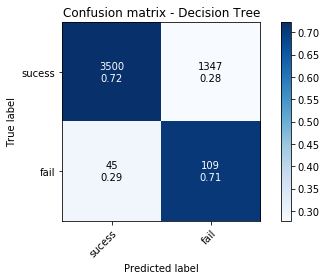

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      4847
           1       0.07      0.71      0.14       154

    accuracy                           0.72      5001
   macro avg       0.53      0.71      0.48      5001
weighted avg       0.96      0.72      0.81      5001


----ROC Curve----
AUC: 0.71
0.7144317411492984 
-----------------



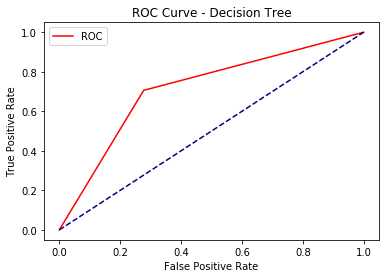

                Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Decision Tree  0.721656   0.074863  0.707792  0.135404  0.263031  109.0   

                   TN  ROC Curve  
Decision Tree  3500.0   0.714944  
For fold 2:
best fold 2
Decision Tree



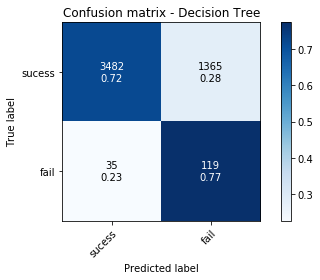

              precision    recall  f1-score   support

           0       0.99      0.72      0.83      4847
           1       0.08      0.77      0.15       154

    accuracy                           0.72      5001
   macro avg       0.54      0.75      0.49      5001
weighted avg       0.96      0.72      0.81      5001


----ROC Curve----
AUC: 0.75
0.7455079993247931 
-----------------



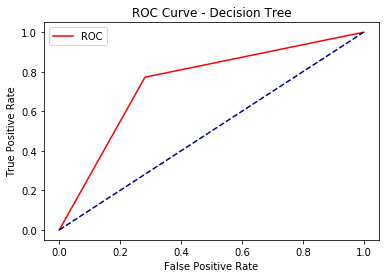

                Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Decision Tree  0.720056   0.080189  0.772727  0.145299  0.283333  119.0   

                   TN  ROC Curve  
Decision Tree  3482.0   0.745555  
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
acuracy 0.71432
precision 0.07515991471215352
recall 0.7362924281984334
f1-score 0.13639661426844016
f2-score 0.26684330052990163
auc best 0.7455548886846597
auc media 0.7249563838243812
Tot:4999 0:4846 1:153
undersample_200301_22


In [132]:
clf = tree.DecisionTreeClassifier()
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Decision Tree', sampling);
all_results = all_results.append(result)
decisionTreeToGraph(bestModel, featuresColumns, class_names, 'undersample')

In [133]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Decision Tree,0.71432,0.07516,0.736292,0.136397,0.266843,1128.0,34588.0,0.724956


In [101]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.745451,0.082151,0.714286,0.147354,0.281330,110.0,3618.0,0.730363
Fold2,0.724855,0.073324,0.681818,0.132409,0.256348,105.0,3520.0,0.704020
Fold3,0.695400,0.068640,0.712418,0.125215,0.247727,109.0,3368.0,0.703641
Fold4,0.699200,0.066709,0.679739,0.121495,0.239521,104.0,3392.0,0.689776
Fold5,0.705200,0.074146,0.751634,0.134977,0.265834,115.0,3411.0,0.727684
Fold6,0.709200,0.075114,0.751634,0.136580,0.268315,115.0,3431.0,0.729747
Fold7,0.711400,0.071713,0.705882,0.130199,0.254958,108.0,3449.0,0.708728
Fold8,0.706800,0.068376,0.679739,0.124253,0.243788,104.0,3430.0,0.693696
Fold9,0.732346,0.077088,0.705882,0.138996,0.268256,108.0,3553.0,0.719532
Fold10,0.725345,0.075800,0.712418,0.137021,0.265854,109.0,3517.0,0.719086


[0.22210145 0.135342   0.17369232 0.19280997 0.27605425]


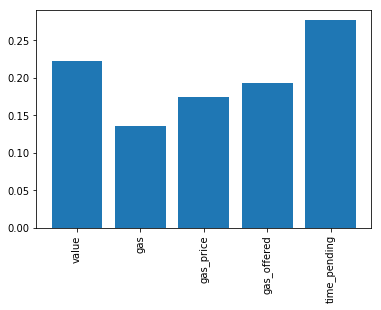

In [88]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Random Forest



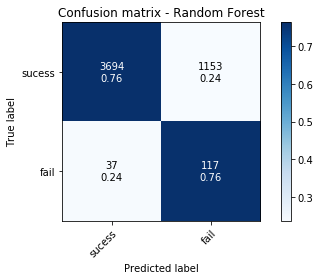

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      4847
           1       0.09      0.76      0.16       154

    accuracy                           0.76      5001
   macro avg       0.54      0.76      0.51      5001
weighted avg       0.96      0.76      0.84      5001


----ROC Curve----
AUC: 0.86
0.8585247535629215 
-----------------



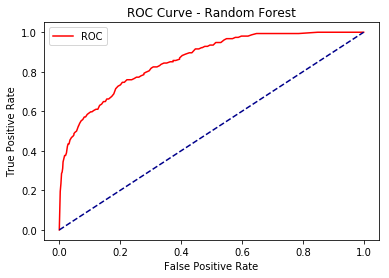

                Acuracy  Precision   Recall  F1-score   F-beta     TP      TN  \
Random Forest  0.762048   0.092126  0.75974  0.164326  0.31018  117.0  3694.0   

               ROC Curve  
Random Forest   0.760931  
For fold 2:
best fold 2
Random Forest



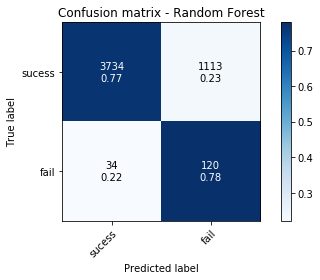

              precision    recall  f1-score   support

           0       0.99      0.77      0.87      4847
           1       0.10      0.78      0.17       154

    accuracy                           0.77      5001
   macro avg       0.54      0.77      0.52      5001
weighted avg       0.96      0.77      0.85      5001


----ROC Curve----
AUC: 0.86
0.8613836648187794 
-----------------



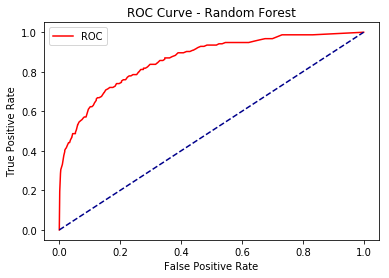

                Acuracy  Precision    Recall  F1-score  F-beta     TP      TN  \
Random Forest  0.770646   0.097324  0.779221  0.173035  0.3245  120.0  3734.0   

               ROC Curve  
Random Forest   0.774797  
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
acuracy 0.75494
precision 0.09026981579148513
recall 0.77088772845953
f1-score 0.16161477933629834
f2-score 0.30737598251002035
auc best 0.7747971030413779
auc media 0.7626627358437056
Tot:4999 0:4846 1:153
rf_undersample_200301_0


In [96]:
clf = RandomForestClassifier(n_estimators=100, random_state=2)
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Random Forest', sampling)
all_results = all_results.append(result)
decisionTreeToGraph(bestModel.estimators_[99], featuresColumns, class_names, 'rf_undersample')

In [97]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Random Forest,0.75494,0.09027,0.770888,0.161615,0.307376,1181.0,36566.0,0.762663


In [98]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.762048,0.092126,0.759740,0.164326,0.310180,117.0,3694.0,0.760931
Fold2,0.770646,0.097324,0.779221,0.173035,0.324500,120.0,3734.0,0.774797
Fold3,0.740800,0.084967,0.764706,0.152941,0.294118,117.0,3587.0,0.752376
Fold4,0.745800,0.090176,0.803922,0.162162,0.311235,123.0,3606.0,0.773943
Fold5,0.750800,0.089406,0.777778,0.160377,0.306227,119.0,3635.0,0.763863
Fold6,0.758200,0.092593,0.784314,0.165631,0.314465,120.0,3671.0,0.770845
Fold7,0.755400,0.087191,0.738562,0.155970,0.296122,113.0,3664.0,0.747247
Fold8,0.757400,0.092934,0.790850,0.166323,0.316092,121.0,3666.0,0.773597
Fold9,0.749750,0.085973,0.745098,0.154158,0.294118,114.0,3634.0,0.747497
Fold10,0.758552,0.090839,0.764706,0.162387,0.307895,117.0,3675.0,0.761532


[0.13539362 0.20999784 0.17726326 0.20787021 0.26947507]


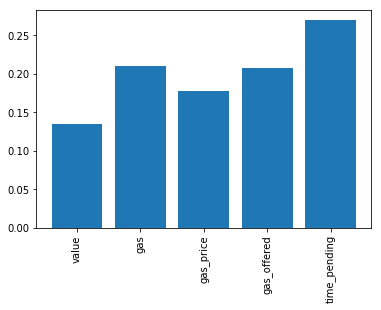

In [98]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Logistic Regression



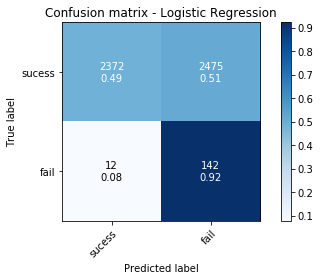

              precision    recall  f1-score   support

           0       0.99      0.49      0.66      4847
           1       0.05      0.92      0.10       154

    accuracy                           0.50      5001
   macro avg       0.52      0.71      0.38      5001
weighted avg       0.97      0.50      0.64      5001


----ROC Curve----
AUC: 0.74
0.7361261082635129 
-----------------



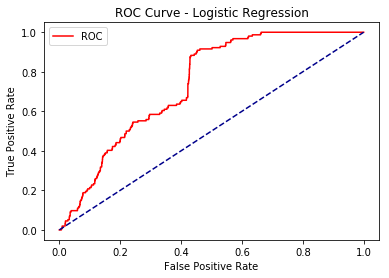

                      Acuracy  Precision    Recall  F1-score   F-beta     TP  \
Logistic Regression  0.502699   0.054261  0.922078   0.10249  0.21961  142.0   

                         TN  ROC Curve  
Logistic Regression  2372.0   0.705726  
For fold 2:
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
acuracy 0.33002
precision 0.04211189732718366
recall 0.9595300261096605
f1-score 0.08068278492823623
f2-score 0.17911538930181553
auc best 0.7057263965660912
auc media 0.6348281741435836
Tot:4999 0:4846 1:153


In [99]:
clf = LogisticRegression(solver='lbfgs', multi_class='multinomial')
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Logistic Regression', sampling)
all_results = all_results.append(result)

In [100]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Logistic Regression,0.33002,0.042112,0.95953,0.080683,0.179115,1470.0,15031.0,0.634828


In [101]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.502699,0.054261,0.922078,0.102490,0.219610,142.0,2372.0,0.705726
Fold2,0.299540,0.041610,0.987013,0.079853,0.178028,152.0,1346.0,0.632355
Fold3,0.286000,0.041096,1.000000,0.078947,0.176471,153.0,1277.0,0.631731
Fold4,0.554400,0.055294,0.843137,0.103781,0.219015,129.0,2643.0,0.694211
Fold5,0.288400,0.040734,0.986928,0.078238,0.174809,151.0,1291.0,0.626639
Fold6,0.269600,0.038512,0.954248,0.074037,0.165796,146.0,1202.0,0.601118
Fold7,0.277600,0.039904,0.980392,0.076687,0.171585,150.0,1238.0,0.617904
Fold8,0.270800,0.039304,0.973856,0.075558,0.169203,149.0,1205.0,0.611232
Fold9,0.281256,0.039861,0.973856,0.076587,0.171264,149.0,1257.0,0.616623
Fold10,0.269854,0.039262,0.973856,0.075481,0.169049,149.0,1200.0,0.610742


For fold 1:
best fold 1
Linear SVM



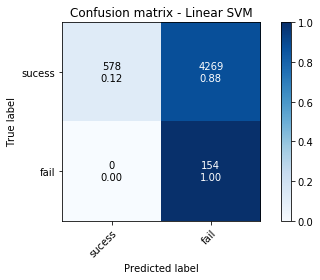

              precision    recall  f1-score   support

           0       1.00      0.12      0.21      4847
           1       0.03      1.00      0.07       154

    accuracy                           0.15      5001
   macro avg       0.52      0.56      0.14      5001
weighted avg       0.97      0.15      0.21      5001


----ROC Curve----
AUC: 0.78
0.7770216682430423 
-----------------



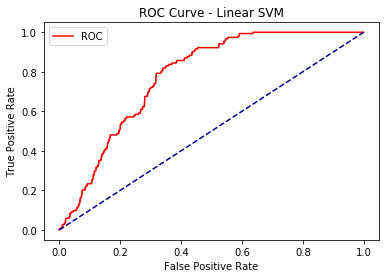

             Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Linear SVM  0.146371   0.034818     1.0  0.067293  0.152808  154.0  578.0   

            ROC Curve  
Linear SVM   0.559625  
For fold 2:
For fold 3:
For fold 4:
For fold 5:
For fold 6:
For fold 7:
For fold 8:
For fold 9:
For fold 10:
acuracy 0.14872
precision 0.03438336888929236
recall 0.9889033942558747
f1-score 0.06645611264640085
f2-score 0.1509264793783622
auc best 0.5596245100061894
auc media 0.5555280622563858
Tot:4999 0:4846 1:153


In [102]:
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Linear SVM', sampling)
all_results = all_results.append(result)

In [103]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Linear SVM,0.14872,0.034383,0.988903,0.066456,0.150926,1515.0,5921.0,0.555528


In [104]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.146371,0.034818,1.000000,0.067293,0.152808,154.0,578.0,0.559625
Fold2,0.151570,0.034812,0.993506,0.067268,0.152664,153.0,605.0,0.559163
Fold3,0.145800,0.034584,1.000000,0.066856,0.151906,153.0,576.0,0.559418
Fold4,0.137200,0.034251,1.000000,0.066234,0.150620,153.0,533.0,0.554982
Fold5,0.151400,0.034593,0.993464,0.066857,0.151818,152.0,605.0,0.559142
Fold6,0.161600,0.034356,0.973856,0.066370,0.150535,149.0,659.0,0.554908
Fold7,0.140800,0.033761,0.980392,0.065274,0.148368,150.0,554.0,0.547345
Fold8,0.159400,0.034483,0.980392,0.066622,0.151149,150.0,647.0,0.556938
Fold9,0.140428,0.033753,0.980392,0.065260,0.148339,150.0,552.0,0.547150
Fold10,0.152631,0.034436,0.986928,0.066549,0.151091,151.0,612.0,0.556609


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Gaussian SVM



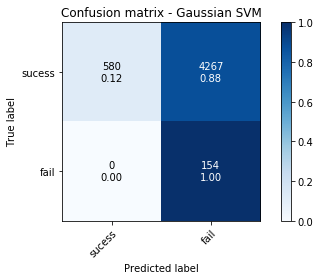

              precision    recall  f1-score   support

           0       1.00      0.12      0.21      4847
           1       0.03      1.00      0.07       154

    accuracy                           0.15      5001
   macro avg       0.52      0.56      0.14      5001
weighted avg       0.97      0.15      0.21      5001


----ROC Curve----
AUC: 0.74
0.7379387169463505 
-----------------



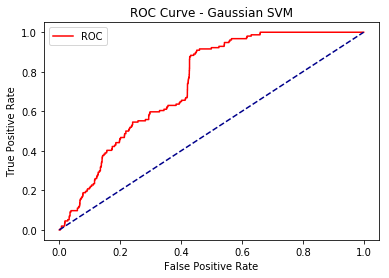

               Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Gaussian SVM  0.146771   0.034834     1.0  0.067322  0.152869  154.0  580.0   

              ROC Curve  
Gaussian SVM   0.559831  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:
best fold 4
Gaussian SVM



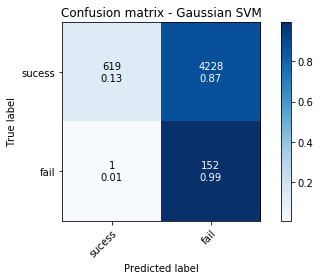

              precision    recall  f1-score   support

           0       1.00      0.13      0.23      4847
           1       0.03      0.99      0.07       153

    accuracy                           0.15      5000
   macro avg       0.52      0.56      0.15      5000
weighted avg       0.97      0.15      0.22      5000


----ROC Curve----
AUC: 0.71
0.7107098117425913 
-----------------



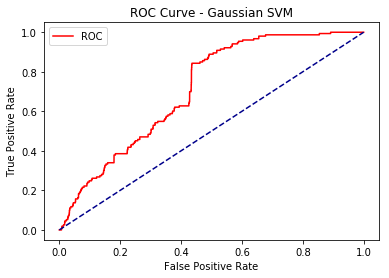

              Acuracy  Precision    Recall  F1-score    F-beta     TP     TN  \
Gaussian SVM   0.1542   0.034703  0.993464  0.067064  0.152244  152.0  619.0   

              ROC Curve  
Gaussian SVM   0.560586  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:
best fold 5
Gaussian SVM



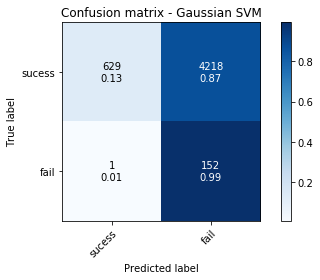

              precision    recall  f1-score   support

           0       1.00      0.13      0.23      4847
           1       0.03      0.99      0.07       153

    accuracy                           0.16      5000
   macro avg       0.52      0.56      0.15      5000
weighted avg       0.97      0.16      0.22      5000


----ROC Curve----
AUC: 0.71
0.7083830575074401 
-----------------



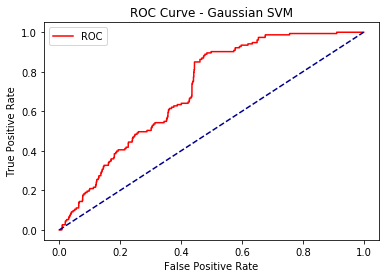

              Acuracy  Precision    Recall  F1-score    F-beta     TP     TN  \
Gaussian SVM   0.1562   0.034783  0.993464  0.067212  0.152549  152.0  629.0   

              ROC Curve  
Gaussian SVM   0.561618  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
acuracy 0.1391
precision 0.03401207821655479
recall 0.9889033942558747
f1-score 0.06576234400434075
f2-score 0.1494937932939946
auc best 0.5616175223269969
auc media 0.5505660662857512
Tot:4999 0:4846 1:153


In [105]:
clf = svm.SVC(kernel='rbf', probability=True) # Gaussian Kernel - gamma=0.1
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Gaussian SVM', sampling)
all_results = all_results.append(result)

In [106]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Gaussian SVM,0.1391,0.034012,0.988903,0.065762,0.149494,1515.0,5440.0,0.550566


In [107]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.146771,0.034834,1.000000,0.067322,0.152869,154.0,580.0,0.559831
Fold2,0.126975,0.033865,0.993506,0.065497,0.149007,153.0,482.0,0.546475
Fold3,0.133400,0.034106,1.000000,0.065962,0.150059,153.0,514.0,0.553022
Fold4,0.154200,0.034703,0.993464,0.067064,0.152244,152.0,619.0,0.560586
Fold5,0.156200,0.034783,0.993464,0.067212,0.152549,152.0,629.0,0.561618
Fold6,0.138400,0.033461,0.973856,0.064698,0.147088,149.0,543.0,0.542942
Fold7,0.134800,0.033535,0.980392,0.064851,0.147493,150.0,524.0,0.544250
Fold8,0.122600,0.033289,0.986928,0.064406,0.146659,151.0,462.0,0.541122
Fold9,0.142428,0.033829,0.980392,0.065402,0.148633,150.0,562.0,0.548182
Fold10,0.135227,0.033766,0.986928,0.065297,0.148505,151.0,525.0,0.547632


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Sigmoid SVM



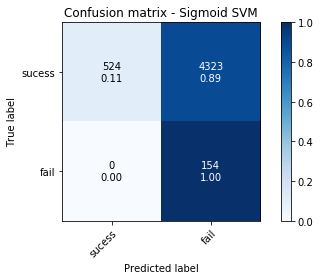

              precision    recall  f1-score   support

           0       1.00      0.11      0.20      4847
           1       0.03      1.00      0.07       154

    accuracy                           0.14      5001
   macro avg       0.52      0.55      0.13      5001
weighted avg       0.97      0.14      0.19      5001


----ROC Curve----
AUC: 0.74
0.7363846695907765 
-----------------



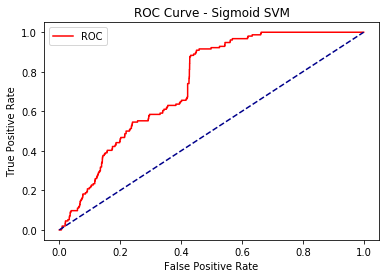

              Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Sigmoid SVM  0.135573   0.034398     1.0  0.066508  0.151188  154.0  524.0   

             ROC Curve  
Sigmoid SVM   0.554054  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:
best fold 3
Sigmoid SVM



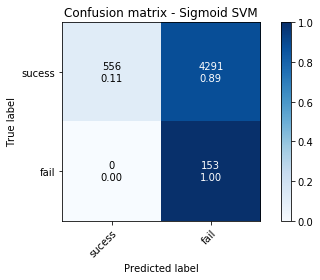

              precision    recall  f1-score   support

           0       1.00      0.11      0.21      4847
           1       0.03      1.00      0.07       153

    accuracy                           0.14      5000
   macro avg       0.52      0.56      0.14      5000
weighted avg       0.97      0.14      0.20      5000


----ROC Curve----
AUC: 0.71
0.7092184236324335 
-----------------



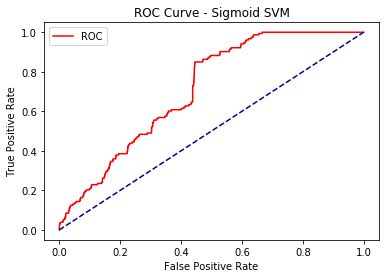

             Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Sigmoid SVM   0.1418   0.034428     1.0  0.066565  0.151305  153.0  556.0   

             ROC Curve  
Sigmoid SVM   0.557355  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
acuracy 0.1238
precision 0.033540756432322696
recall 0.9921671018276762
f1-score 0.06488794023479189
f2-score 0.14772771449675384
auc best 0.5573550649886527
auc media 0.5442546862663139
Tot:4999 0:4846 1:153


In [108]:
clf = svm.SVC(kernel='sigmoid', probability=True) # Sigmoid Kernel
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Sigmoid SVM', sampling)
all_results = all_results.append(result)

/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Sigmoid SVM



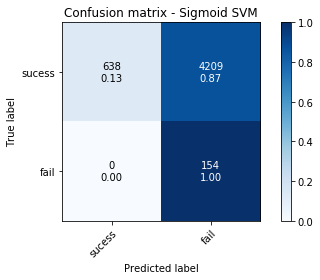

              precision    recall  f1-score   support

           0       1.00      0.13      0.23      4847
           1       0.04      1.00      0.07       154

    accuracy                           0.16      5001
   macro avg       0.52      0.57      0.15      5001
weighted avg       0.97      0.16      0.23      5001


----ROC Curve----
AUC: 0.73
0.7346738778036488 
-----------------



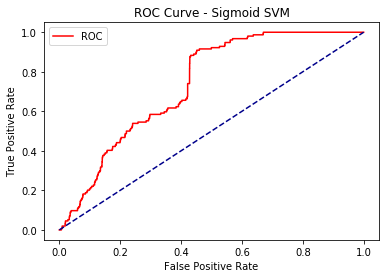

              Acuracy  Precision  Recall  F1-score   F-beta     TP     TN  \
Sigmoid SVM  0.158368   0.035297     1.0  0.068187  0.15465  154.0  638.0   

             ROC Curve  
Sigmoid SVM   0.565814  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 2:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:
best fold 8
Sigmoid SVM



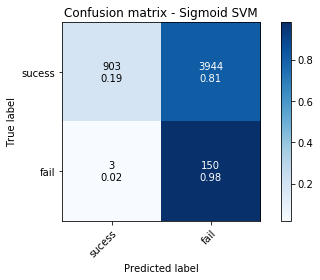

              precision    recall  f1-score   support

           0       1.00      0.19      0.31      4847
           1       0.04      0.98      0.07       153

    accuracy                           0.21      5000
   macro avg       0.52      0.58      0.19      5000
weighted avg       0.97      0.21      0.31      5000


----ROC Curve----
AUC: 0.66
0.6641895600135386 
-----------------



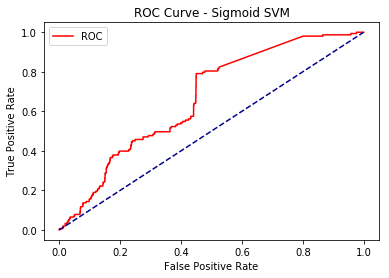

             Acuracy  Precision    Recall  F1-score    F-beta     TP     TN  \
Sigmoid SVM   0.2106   0.036639  0.980392  0.070638  0.159371  150.0  903.0   

             ROC Curve  
Sigmoid SVM   0.583346  


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
acuracy 0.13392
precision 0.03385707271347587
recall 0.9902088772845953
f1-score 0.0654754197418965
f2-score 0.14891820787686028
auc best 0.5833464807420802
auc media 0.5485269376795466
Tot:4999 0:4846 1:153


In [111]:
clf = svm.SVC(kernel='sigmoid', probability=True)#, C=10000) # Sigmoid Kernel
sampling = RandomUnderSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Sigmoid SVM', sampling)
all_results = all_results.append(result)

In [112]:
result

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Sigmoid SVM,0.13392,0.033857,0.990209,0.065475,0.148918,1517.0,5179.0,0.548527


In [113]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.158368,0.035297,1.000000,0.068187,0.154650,154.0,638.0,0.565814
Fold2,0.121776,0.033671,0.993506,0.065134,0.148256,153.0,456.0,0.543793
Fold3,0.113800,0.033377,1.000000,0.064598,0.147229,153.0,416.0,0.542913
Fold4,0.128400,0.033917,1.000000,0.065609,0.149327,153.0,489.0,0.550444
Fold5,0.123400,0.033524,0.993464,0.064860,0.147688,152.0,465.0,0.544700
Fold6,0.107600,0.032545,0.980392,0.062999,0.143651,150.0,388.0,0.530221
Fold7,0.129000,0.033319,0.980392,0.064447,0.146656,150.0,495.0,0.541259
Fold8,0.210600,0.036639,0.980392,0.070638,0.159371,150.0,903.0,0.583346
Fold9,0.129226,0.033333,0.980392,0.064475,0.146714,150.0,496.0,0.541372
Fold10,0.117023,0.033297,0.993464,0.064434,0.146803,152.0,433.0,0.541408


## Resultados Gerais

In [114]:
all_results

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Decision Tree,0.71606,0.073655,0.714099,0.133537,0.260712,1094.0,34709.0,0.715121
Random Forest,0.75304,0.088870,0.763055,0.159199,0.303132,1169.0,36483.0,0.757913
Logistic Regression,0.33002,0.042112,0.959530,0.080683,0.179115,1470.0,15031.0,0.634828
Linear SVM,0.14872,0.034383,0.988903,0.066456,0.150926,1515.0,5921.0,0.555528
Gaussian SVM,0.13910,0.034012,0.988903,0.065762,0.149494,1515.0,5440.0,0.550566
Sigmoid SVM,0.12380,0.033541,0.992167,0.064888,0.147728,1520.0,4670.0,0.544255
Sigmoid SVM,0.13392,0.033857,0.990209,0.065475,0.148918,1517.0,5179.0,0.548527


In [115]:
print(all_results.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  Acuracy &  Precision &    Recall &  F1-score &    F-beta &      TP &       TN &  ROC Curve \\
\midrule
Decision Tree       &  0.71606 &   0.073655 &  0.714099 &  0.133537 &  0.260712 &  1094.0 &  34709.0 &   0.715121 \\
Random Forest       &  0.75304 &   0.088870 &  0.763055 &  0.159199 &  0.303132 &  1169.0 &  36483.0 &   0.757913 \\
Logistic Regression &  0.33002 &   0.042112 &  0.959530 &  0.080683 &  0.179115 &  1470.0 &  15031.0 &   0.634828 \\
Linear SVM          &  0.14872 &   0.034383 &  0.988903 &  0.066456 &  0.150926 &  1515.0 &   5921.0 &   0.555528 \\
Gaussian SVM        &  0.13910 &   0.034012 &  0.988903 &  0.065762 &  0.149494 &  1515.0 &   5440.0 &   0.550566 \\
Sigmoid SVM         &  0.12380 &   0.033541 &  0.992167 &  0.064888 &  0.147728 &  1520.0 &   4670.0 &   0.544255 \\
Sigmoid SVM         &  0.13392 &   0.033857 &  0.990209 &  0.065475 &  0.148918 &  1517.0 &   5179.0 &   0.548527 \\
\bottomrule
\end{tabular}



### Oversample

In [ ]:
all_results = metrics_structure()

For fold 1:
best fold 1
Decision Tree

              precision    recall  f1-score   support

           0       1.00      0.44      0.61      4847
           1       0.05      0.96      0.10       154

    accuracy                           0.45      5001
   macro avg       0.52      0.70      0.35      5001
weighted avg       0.97      0.45      0.59      5001

-------
Metrics
-------
Acurácia: 0.4517096580683863

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.05131761442441054
Precisão macro: 0.5242417075428619
Precisão micro: 0.4517096580683863

Recall normal: 0.961038961038961

Recall macro: 0.6982830456112898
Recall micro: 0.4517096580683863

F1-Score normal: 0.09743252139565502

F1-Score macro: 0.35184664553412853
F1-Score micro: 0.4517096580683863

Fbeta1 normal: 0.09743252139565502

Fbeta1 macro: 0.35184664553412853
Fbeta1 micro: 0.4

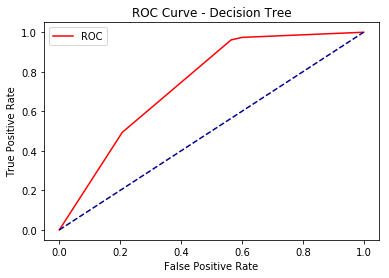

               Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Decision Tree  0.45171   0.051318  0.961039  0.097433  0.211429  148.0   

                   TN  ROC Curve  
Decision Tree  2111.0   0.698283  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
best fold 3
Decision Tree

              precision    recall  f1-score   support

           0       0.99      0.59      0.74      4847
           1       0.06      0.83      0.11       153

    accuracy                           0.59      5000
   macro avg       0.53      0.71      0.42      5000
weighted avg       0.96      0.59      0.72      5000

-------
Metrics
-------
Acurácia: 0.594

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.059596433599249175
Precisão macro: 0.5252670212611095
Precisão micro: 0.594

Recall normal: 0.8300653594771242

Recall macro:

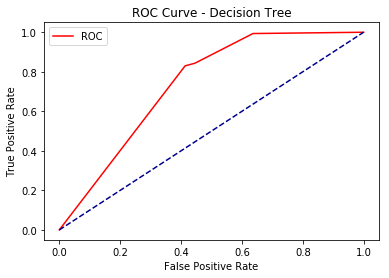

               Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Decision Tree    0.594   0.059596  0.830065  0.111208  0.231498  127.0   

                   TN  ROC Curve  
Decision Tree  2843.0   0.708307  
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153
oversample_200229_5


In [140]:
clf = tree.DecisionTreeClassifier()
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Decision Tree', sampling)
all_results = all_results.append(result)
decisionTreeToGraph(bestModel, featuresColumns, class_names, 'oversample')

In [ ]:
result

In [78]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.565887,0.036322,0.512987,0.067840,0.141526,79.0,2751.0,0.540277
Fold2,0.564687,0.042515,0.610390,0.079493,0.166254,94.0,2730.0,0.586812
Fold3,0.559800,0.039154,0.568627,0.073263,0.153493,87.0,2712.0,0.564074
Fold4,0.563000,0.039855,0.575163,0.074545,0.156028,88.0,2727.0,0.568890
Fold5,0.565800,0.038004,0.542484,0.071031,0.148426,83.0,2746.0,0.554510
Fold6,0.561000,0.039675,0.575163,0.074230,0.155477,88.0,2717.0,0.567858
Fold7,0.555600,0.038376,0.562092,0.071846,0.150719,86.0,2692.0,0.558743
Fold8,0.569400,0.038745,0.549020,0.072383,0.151079,84.0,2763.0,0.559531
Fold9,0.568314,0.043280,0.620915,0.080920,0.169220,95.0,2746.0,0.593784
Fold10,0.567113,0.043991,0.633987,0.082273,0.172169,97.0,2738.0,0.599494


[0.80029326 0.19970674 0.         0.         0.        ]


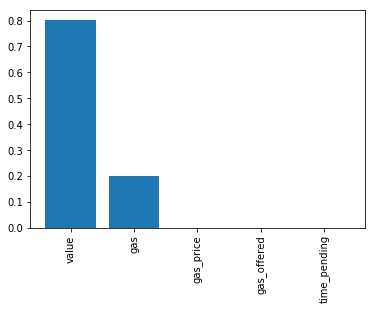

In [133]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Random Forest

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4847
           1       0.41      0.29      0.34       154

    accuracy                           0.97      5001
   macro avg       0.69      0.64      0.66      5001
weighted avg       0.96      0.97      0.96      5001

-------
Metrics
-------
Acurácia: 0.9650069986002799

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.40540540540540543
Precisão macro: 0.6915575084286741
Precisão micro: 0.9650069986002799

Recall normal: 0.2922077922077922

Recall macro: 0.6392955610512863
Recall micro: 0.9650069986002799

F1-Score normal: 0.33962264150943394

F1-Score macro: 0.6608249799926753
F1-Score micro: 0.9650069986002799

Fbeta1 normal: 0.33962264150943394

Fbeta1 macro: 0.6608249799926753
Fbeta1 micro: 0.96

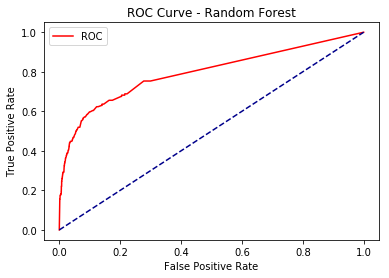

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Random Forest  0.965007   0.405405  0.292208  0.339623  0.309491  45.0   

                   TN  ROC Curve  
Random Forest  4781.0   0.639296  
Tot:5001 0:4847 1:154
For fold 2:
best fold 2
Random Forest

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4847
           1       0.48      0.42      0.45       154

    accuracy                           0.97      5001
   macro avg       0.73      0.70      0.72      5001
weighted avg       0.97      0.97      0.97      5001

-------
Metrics
-------
Acurácia: 0.9684063187362527

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.48484848484848486
Precisão macro: 0.7331820982467933
Precisão micro: 0.9684063187362527

Recall normal: 0.4155844155844156

Recall macro: 0.700777

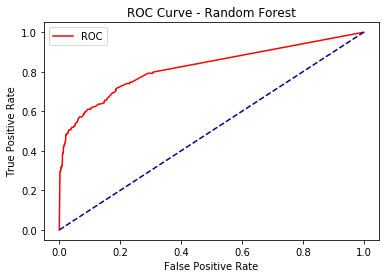

                Acuracy  Precision    Recall  F1-score    F-beta    TP  \
Random Forest  0.968406   0.484848  0.415584  0.447552  0.427807  64.0   

                   TN  ROC Curve  
Random Forest  4779.0   0.700778  
Tot:5001 0:4847 1:154
For fold 3:
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153
rf_oversample_200229_5


In [146]:
clf = RandomForestClassifier(n_estimators=100, random_state=2)
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Random Forest', sampling)
all_results = all_results.append(result)
decisionTreeToGraph(bestModel.estimators_[99], featuresColumns, class_names, 'rf_oversample')

In [ ]:
result

In [147]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.965007,0.405405,0.292208,0.339623,0.309491,45.0,4781.0,0.639296
Fold2,0.968406,0.484848,0.415584,0.447552,0.427807,64.0,4779.0,0.700778
Fold3,0.962400,0.375887,0.346405,0.360544,0.351926,53.0,4759.0,0.664125
Fold4,0.966000,0.433071,0.359477,0.392857,0.372124,55.0,4775.0,0.672311
Fold5,0.961800,0.364286,0.333333,0.348123,0.339096,51.0,4758.0,0.657486
Fold6,0.967800,0.468254,0.385621,0.422939,0.399729,59.0,4780.0,0.685899
Fold7,0.963400,0.388060,0.339869,0.362369,0.348525,52.0,4765.0,0.661476
Fold8,0.963800,0.392308,0.333333,0.360424,0.343666,51.0,4768.0,0.658517
Fold9,0.964593,0.410448,0.359477,0.383275,0.368633,55.0,4767.0,0.671588
Fold10,0.965593,0.431655,0.392157,0.410959,0.399467,60.0,4767.0,0.687927


[0.43269952 0.27114422 0.00286005 0.26380606 0.02949014]


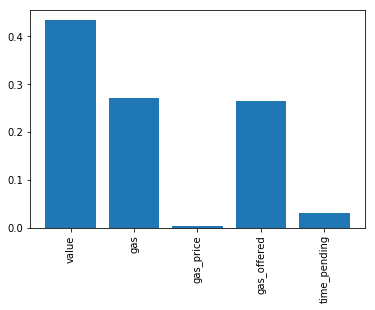

In [135]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Logistic Regression

              precision    recall  f1-score   support

           0       1.00      0.27      0.42      4847
           1       0.04      1.00      0.08       154

    accuracy                           0.29      5001
   macro avg       0.52      0.63      0.25      5001
weighted avg       0.97      0.29      0.41      5001

-------
Metrics
-------
Acurácia: 0.28774245150969807

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.041442411194833155
Precisão macro: 0.5207212055974165
Precisão micro: 0.28774245150969807

Recall normal: 1.0

Recall macro: 0.6325562203424799
Recall micro: 0.28774245150969807

F1-Score normal: 0.07958656330749354

F1-Score macro: 0.2493497069635967
F1-Score micro: 0.28774245150969807

Fbeta1 normal: 0.07958656330749354

Fbeta1 macro: 0.2493497069635967
Fbeta1 micro: 0.287742

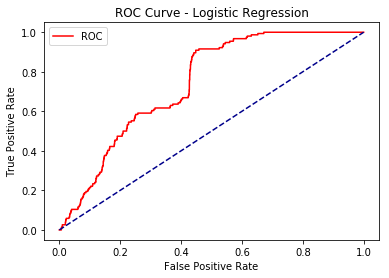

                      Acuracy  Precision  Recall  F1-score    F-beta     TP  \
Logistic Regression  0.287742   0.041442     1.0  0.079587  0.177747  154.0   

                         TN  ROC Curve  
Logistic Regression  1285.0   0.632556  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153


In [81]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Logistic Regression', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [82]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.287742,0.041442,1.000000,0.079587,0.177747,154.0,1285.0,0.632556
Fold2,0.287942,0.040959,0.987013,0.078655,0.175641,152.0,1288.0,0.626372
Fold3,0.279800,0.040757,1.000000,0.078321,0.175218,153.0,1246.0,0.628533
Fold4,0.271600,0.039831,0.986928,0.076572,0.171474,151.0,1207.0,0.617974
Fold5,0.286200,0.040613,0.986928,0.078016,0.174365,151.0,1280.0,0.625504
Fold6,0.274800,0.038778,0.954248,0.074528,0.166781,146.0,1228.0,0.603800
Fold7,0.264000,0.039195,0.980392,0.075377,0.168957,150.0,1170.0,0.610889
Fold8,0.278000,0.039680,0.973856,0.076254,0.170598,149.0,1241.0,0.614945
Fold9,0.278256,0.039702,0.973856,0.076293,0.170676,149.0,1242.0,0.615075
Fold10,0.269854,0.039262,0.973856,0.075481,0.169049,149.0,1200.0,0.610742


In [ ]:
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Linear SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [ ]:
results_folds

In [ ]:
clf = svm.SVC(kernel='rbf', probability=True) # Gaussian Kernel - gamma=0.1
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Gaussian SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [ ]:
results_folds

In [ ]:
clf = svm.SVC(kernel='sigmoid', probability=True) # Sigmoid Kernel
sampling = RandomOverSampler()
result, results_folds, bestModel = cv(X, y, clf, 'Sigmoid SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [ ]:
results_folds

## Resultados Gerais

In [ ]:
all_results

In [ ]:
print(all_results.to_latex())

### SMOTE

In [28]:
all_results = metrics_structure()

For fold 1:
best fold 1
Decision Tree

              precision    recall  f1-score   support

           0       0.99      0.57      0.73      4847
           1       0.06      0.88      0.11       154

    accuracy                           0.58      5001
   macro avg       0.53      0.72      0.42      5001
weighted avg       0.96      0.58      0.71      5001

-------
Metrics
-------
Acurácia: 0.5804839032193562

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.06097560975609756
Precisão macro: 0.5270791217061794
Precisão micro: 0.5804839032193562

Recall normal: 0.8766233766233766

Recall macro: 0.7238491341544777
Recall micro: 0.5804839032193562

F1-Score normal: 0.11402027027027026

F1-Score macro: 0.419598555360443
F1-Score micro: 0.5804839032193562

Fbeta1 normal: 0.11402027027027026

Fbeta1 macro: 0.419598555360443
Fbeta1 micro: 0.5804

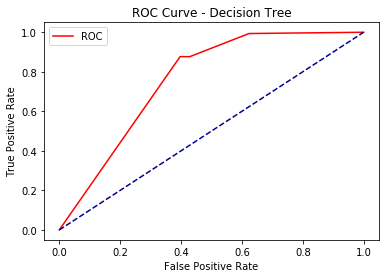

                Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Decision Tree  0.580484   0.060976  0.876623   0.11402  0.238516  135.0   

                   TN  ROC Curve  
Decision Tree  2768.0   0.723849  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153
smote_200229_4


In [136]:
clf = tree.DecisionTreeClassifier(max_depth=2)
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Decision Tree', sampling)
all_results = all_results.append(result)
decisionTreeToGraph(bestModel, featuresColumns, class_names, 'smote')

In [ ]:
result

In [81]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.580484,0.060976,0.876623,0.114020,0.238516,135.0,2768.0,0.723849
Fold2,0.610878,0.058621,0.772727,0.108974,0.224868,119.0,2936.0,0.689231
Fold3,0.594000,0.059596,0.830065,0.111208,0.231498,127.0,2843.0,0.708307
Fold4,0.569200,0.057105,0.843137,0.106965,0.224660,129.0,2717.0,0.701845
Fold5,0.596000,0.059046,0.816993,0.110132,0.229022,125.0,2855.0,0.703009
Fold6,0.607200,0.059367,0.797386,0.110507,0.228721,122.0,2914.0,0.699291
Fold7,0.598200,0.055981,0.764706,0.104325,0.216506,117.0,2874.0,0.678825
Fold8,0.590400,0.055373,0.771242,0.103327,0.215093,118.0,2834.0,0.677967
Fold9,0.591918,0.055582,0.771242,0.103691,0.215722,118.0,2841.0,0.678749
Fold10,0.595519,0.055212,0.758170,0.102928,0.213785,116.0,2861.0,0.674277


[0.7877405 0.        0.        0.2122595 0.       ]


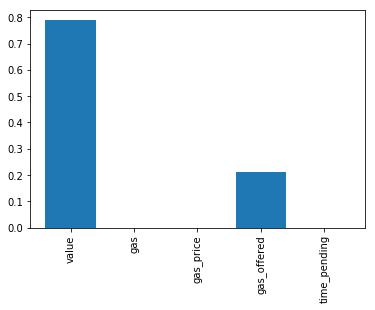

In [137]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Random Forest

              precision    recall  f1-score   support

           0       0.99      0.60      0.75      4847
           1       0.07      0.88      0.12       154

    accuracy                           0.61      5001
   macro avg       0.53      0.74      0.44      5001
weighted avg       0.96      0.61      0.73      5001

-------
Metrics
-------
Acurácia: 0.610877824435113

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.06547041707080505
Precisão macro: 0.5295028165653447
Precisão micro: 0.610877824435113

Recall normal: 0.8766233766233766

Recall macro: 0.7395289360938215
Recall micro: 0.610877824435113

F1-Score normal: 0.12184115523465704

F1-Score macro: 0.4359526865307628
F1-Score micro: 0.610877824435113

Fbeta1 normal: 0.12184115523465704

Fbeta1 macro: 0.4359526865307628
Fbeta1 micro: 0.610877

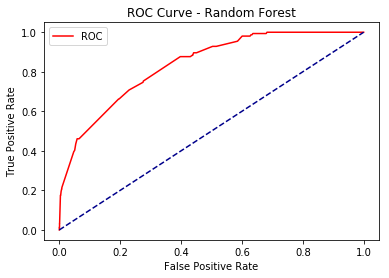

                Acuracy  Precision    Recall  F1-score    F-beta     TP  \
Random Forest  0.610878    0.06547  0.876623  0.121841  0.252054  135.0   

                   TN  ROC Curve  
Random Forest  2920.0   0.739529  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153
rf_smote_200229_4


In [138]:
clf = RandomForestClassifier(n_estimators=100, random_state=2, max_depth=2)
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Random Forest', sampling)
all_results = all_results.append(result)
decisionTreeToGraph(bestModel.estimators_[99], featuresColumns, class_names, 'rf_smote')

In [ ]:
result

In [83]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.919616,0.182051,0.461039,0.261029,0.352883,71.0,4528.0,0.697613
Fold2,0.920616,0.201474,0.532468,0.292335,0.400782,82.0,4522.0,0.732708
Fold3,0.915600,0.187935,0.529412,0.277397,0.388303,81.0,4497.0,0.728601
Fold4,0.924400,0.204724,0.509804,0.292135,0.392749,78.0,4544.0,0.723646
Fold5,0.909200,0.164811,0.483660,0.245847,0.348728,74.0,4472.0,0.703146
Fold6,0.924000,0.209719,0.535948,0.301471,0.408774,82.0,4538.0,0.736098
Fold7,0.918000,0.181141,0.477124,0.262590,0.359606,73.0,4517.0,0.704520
Fold8,0.917600,0.189448,0.516340,0.277193,0.383868,79.0,4509.0,0.723303
Fold9,0.911782,0.177130,0.516340,0.263773,0.373346,79.0,4479.0,0.720304
Fold10,0.916583,0.200000,0.575163,0.296796,0.418251,88.0,4494.0,0.751263


[0.42662459 0.27490796 0.00717796 0.2671785  0.02411099]


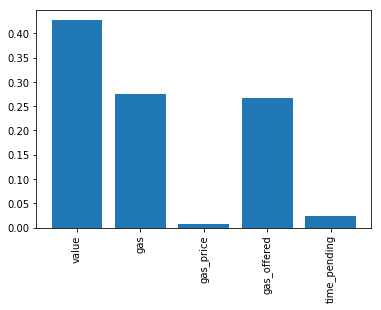

In [139]:
#Feature Importances

print(bestModel.feature_importances_)
height = bestModel.feature_importances_
bars = X.columns
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation = 90)
plt.show()

For fold 1:
best fold 1
Logistic Regression



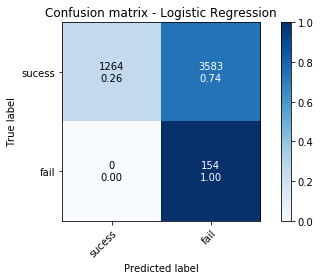

              precision    recall  f1-score   support

           0       1.00      0.26      0.41      4847
           1       0.04      1.00      0.08       154

    accuracy                           0.28      5001
   macro avg       0.52      0.63      0.25      5001
weighted avg       0.97      0.28      0.40      5001


----ROC Curve----
AUC: 0.74
0.7400942878042116 
-----------------



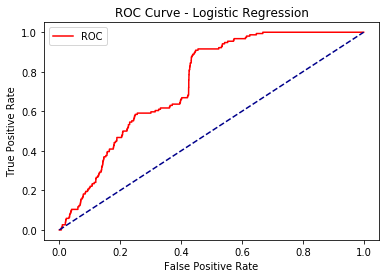

                      Acuracy  Precision  Recall  F1-score   F-beta     TP  \
Logistic Regression  0.283543    0.04121     1.0  0.079157  0.17689  154.0   

                         TN  ROC Curve  
Logistic Regression  1264.0    0.63039  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153


In [161]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Logistic Regression', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [34]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.284343,0.041254,1.000000,0.079238,0.177052,154.0,1268.0,0.630803
Fold2,0.281344,0.040598,0.987013,0.077989,0.174312,152.0,1255.0,0.622968
Fold3,0.270600,0.040263,1.000000,0.077410,0.173391,153.0,1200.0,0.623788
Fold4,0.272600,0.039884,0.986928,0.076669,0.171669,151.0,1212.0,0.618490
Fold5,0.281800,0.040374,0.986928,0.077575,0.173483,151.0,1258.0,0.623235
Fold6,0.274000,0.038737,0.954248,0.074452,0.166629,146.0,1224.0,0.603388
Fold7,0.263000,0.039144,0.980392,0.075282,0.168767,150.0,1165.0,0.610374
Fold8,0.273000,0.039418,0.973856,0.075769,0.169627,149.0,1216.0,0.612367
Fold9,0.274455,0.039502,0.973856,0.075924,0.169936,149.0,1223.0,0.613115
Fold10,0.269854,0.039262,0.973856,0.075481,0.169049,149.0,1200.0,0.610742


For fold 1:
best fold 1
Linear SVM

              precision    recall  f1-score   support

           0       1.00      0.18      0.31      4847
           1       0.04      1.00      0.07       154

    accuracy                           0.21      5001
   macro avg       0.52      0.59      0.19      5001
weighted avg       0.97      0.21      0.30      5001

-------
Metrics
-------
Acurácia: 0.20535892821435714

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.037306201550387594
Precisão macro: 0.5186531007751938
Precisão micro: 0.20535892821435714

Recall normal: 1.0

Recall macro: 0.5900557045595214
Recall micro: 0.20535892821435714

F1-Score normal: 0.07192900513778608

F1-Score macro: 0.18858688019127068
F1-Score micro: 0.20535892821435714

Fbeta1 normal: 0.07192900513778608

Fbeta1 macro: 0.18858688019127068
Fbeta1 micro: 0.2053589282143

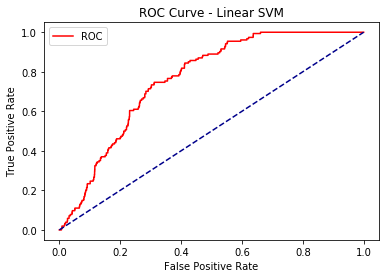

             Acuracy  Precision  Recall  F1-score   F-beta     TP     TN  \
Linear SVM  0.205359   0.037306     1.0  0.071929  0.16231  154.0  873.0   

            ROC Curve  
Linear SVM   0.590056  
Tot:5001 0:4847 1:154
For fold 2:
Tot:5001 0:4847 1:154
For fold 3:
best fold 3
Linear SVM

              precision    recall  f1-score   support

           0       1.00      0.18      0.31      4847
           1       0.04      1.00      0.07       153

    accuracy                           0.21      5000
   macro avg       0.52      0.59      0.19      5000
weighted avg       0.97      0.21      0.30      5000

-------
Metrics
-------
Acurácia: 0.2058

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.037099903006789524
Precisão macro: 0.5185499515033948
Precisão micro: 0.2058

Recall normal: 1.0

Recall macro: 0.59036517433464
Recall micro: 0.

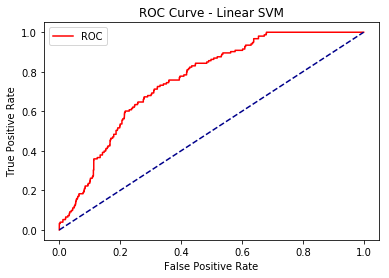

            Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Linear SVM   0.2058     0.0371     1.0  0.071545  0.161529  153.0  876.0   

            ROC Curve  
Linear SVM   0.590365  
Tot:5000 0:4847 1:153
For fold 4:
Tot:5000 0:4847 1:153
For fold 5:
best fold 5
Linear SVM

              precision    recall  f1-score   support

           0       1.00      0.19      0.32      4847
           1       0.04      0.99      0.07       153

    accuracy                           0.21      5000
   macro avg       0.52      0.59      0.19      5000
weighted avg       0.97      0.21      0.31      5000

-------
Metrics
-------
Acurácia: 0.2132

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.037209302325581395
Precisão macro: 0.518058203075359
Precisão micro: 0.2132

Recall normal: 0.9934640522875817

Recall macro: 0.5910171509632668


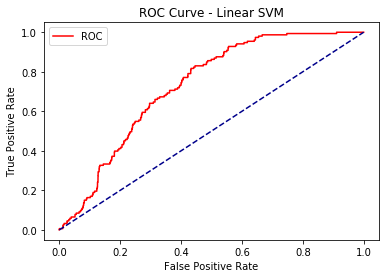

            Acuracy  Precision    Recall  F1-score    F-beta     TP     TN  \
Linear SVM   0.2132   0.037209  0.993464  0.071732  0.161805  152.0  914.0   

            ROC Curve  
Linear SVM   0.591017  
Tot:5000 0:4847 1:153
For fold 6:
Tot:5000 0:4847 1:153
For fold 7:
Tot:5000 0:4847 1:153
For fold 8:
Tot:5000 0:4847 1:153
For fold 9:
Tot:4999 0:4846 1:153
For fold 10:
Tot:4999 0:4846 1:153


In [35]:
clf = svm.SVC(kernel='linear', probability=True) # Linear Kernel
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Linear SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [36]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.205359,0.037306,1.000000,0.071929,0.162310,154.0,873.0,0.590056
Fold2,0.207359,0.037172,0.993506,0.071663,0.161665,153.0,884.0,0.587944
Fold3,0.205800,0.037100,1.000000,0.071545,0.161529,153.0,876.0,0.590365
Fold4,0.204800,0.036606,0.986928,0.070594,0.159384,151.0,873.0,0.583520
Fold5,0.213200,0.037209,0.993464,0.071732,0.161805,152.0,914.0,0.591017
Fold6,0.226400,0.036667,0.960784,0.070639,0.159056,147.0,985.0,0.582001
Fold7,0.202000,0.036258,0.980392,0.069930,0.157928,150.0,860.0,0.578911
Fold8,0.211000,0.036657,0.980392,0.070671,0.159439,150.0,905.0,0.583553
Fold9,0.219444,0.036817,0.973856,0.070952,0.159906,149.0,948.0,0.584741
Fold10,0.206841,0.036479,0.980392,0.070340,0.158764,150.0,884.0,0.581405


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Gaussian SVM

              precision    recall  f1-score   support

           0       1.00      0.18      0.31      4847
           1       0.04      1.00      0.07       154

    accuracy                           0.21      5001
   macro avg       0.52      0.59      0.19      5001
weighted avg       0.97      0.21      0.30      5001

-------
Metrics
-------
Acurácia: 0.20835832833433313

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.037442256260637005
Precisão macro: 0.5187211281303185
Precisão micro: 0.20835832833433313

Recall normal: 1.0

Recall macro: 0.5916030534351145
Recall micro: 0.20835832833433313

F1-Score normal: 0.07218186079212563

F1-Score macro: 0.19092964007348215
F1-Score micro: 0.20835832833433313

Fbeta1 normal: 0.07218186079212563

Fbeta1 macro: 0.19092964007348215
Fbeta1 micro: 0.20835832833

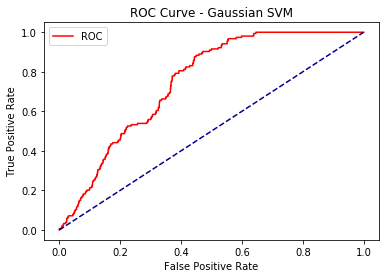

               Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Gaussian SVM  0.208358   0.037442     1.0  0.072182  0.162825  154.0  888.0   

              ROC Curve  
Gaussian SVM   0.591603  
Tot:5001 0:4847 1:154


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 2:
Tot:5001 0:4847 1:154


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:
best fold 3
Gaussian SVM

              precision    recall  f1-score   support

           0       1.00      0.18      0.31      4847
           1       0.04      1.00      0.07       153

    accuracy                           0.21      5000
   macro avg       0.52      0.59      0.19      5000
weighted avg       0.97      0.21      0.30      5000

-------
Metrics
-------
Acurácia: 0.209

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.037244401168451804
Precisão macro: 0.5186222005842259
Precisão micro: 0.209

Recall normal: 1.0

Recall macro: 0.5920156798019394
Recall micro: 0.209

F1-Score normal: 0.07181412813893452

F1-Score macro: 0.1913348389431386
F1-Score micro: 0.209

Fbeta1 normal: 0.07181412813893452

Fbeta1 macro: 0.1913348389431386
Fbeta1 micro: 0.209

Fbeta2 normal: 0.1620762711864407

Fbeta2 macro: 0.1909986878614

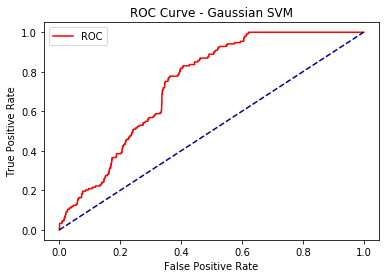

              Acuracy  Precision  Recall  F1-score    F-beta     TP     TN  \
Gaussian SVM    0.209   0.037244     1.0  0.071814  0.162076  153.0  892.0   

              ROC Curve  
Gaussian SVM   0.592016  
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
Tot:4999 0:4846 1:153


In [37]:
clf = svm.SVC(kernel='rbf', probability=True) #, C=100000) # Gaussian Kernel - gamma=0.1
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Gaussian SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [38]:
results_folds

,Acuracy,Precision,Recall,F1-score,F-beta,TP,TN,ROC Curve
Fold1,0.208358,0.037442,1.000000,0.072182,0.162825,154.0,888.0,0.591603
Fold2,0.206959,0.037154,0.993506,0.071629,0.161597,153.0,882.0,0.587737
Fold3,0.209000,0.037244,1.000000,0.071814,0.162076,153.0,892.0,0.592016
Fold4,0.204600,0.036597,0.986928,0.070577,0.159350,151.0,872.0,0.583417
Fold5,0.211200,0.037118,0.993464,0.071563,0.161462,152.0,904.0,0.589986
Fold6,0.223600,0.036770,0.967320,0.070847,0.159586,148.0,970.0,0.583722
Fold7,0.200600,0.036197,0.980392,0.069816,0.157696,150.0,853.0,0.578189
Fold8,0.208400,0.036541,0.980392,0.070456,0.158999,150.0,892.0,0.582212
Fold9,0.215843,0.036654,0.973856,0.070650,0.159290,149.0,930.0,0.582884
Fold10,0.204841,0.036390,0.980392,0.070175,0.158428,150.0,874.0,0.580374


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 1:
best fold 1
Sigmoid SVM

              precision    recall  f1-score   support

           0       0.97      0.57      0.72      4847
           1       0.04      0.51      0.07       154

    accuracy                           0.57      5001
   macro avg       0.50      0.54      0.39      5001
weighted avg       0.94      0.57      0.70      5001

-------
Metrics
-------
Acurácia: 0.5662867426514697

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.03592814371257485
Precisão macro: 0.5045365100188316
Precisão micro: 0.5662867426514697

Recall normal: 0.5064935064935064

Recall macro: 0.5373400068056556
Recall micro: 0.5662867426514697

F1-Score normal: 0.0670967741935484

F1-Score macro: 0.39228226751881407
F1-Score micro: 0.5662867426514697

Fbeta1 normal: 0.0670967741935484

Fbeta1 macro: 0.39228226751881407
Fbeta1 micro: 0.5662

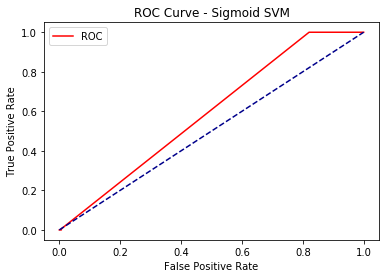

              Acuracy  Precision    Recall  F1-score    F-beta    TP      TN  \
Sigmoid SVM  0.566287   0.035928  0.506494  0.067097  0.139935  78.0  2754.0   

             ROC Curve  
Sigmoid SVM    0.53734  
Tot:5001 0:4847 1:154


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 2:
best fold 2
Sigmoid SVM

              precision    recall  f1-score   support

           0       0.98      0.56      0.71      4847
           1       0.04      0.60      0.08       154

    accuracy                           0.56      5001
   macro avg       0.51      0.58      0.40      5001
weighted avg       0.95      0.56      0.70      5001

-------
Metrics
-------
Acurácia: 0.5644871025794841

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.04208144796380091
Precisão macro: 0.5101127411800374
Precisão micro: 0.5644871025794841

Recall normal: 0.6038961038961039

Recall macro: 0.5835655473060053
Recall micro: 0.5644871025794841

F1-Score normal: 0.07868020304568529

F1-Score macro: 0.3967635107922849
F1-Score micro: 0.5644871025794841

Fbeta1 normal: 0.07868020304568529

Fbeta1 macro: 0.3967635107922849
Fbeta1 micro: 0.5644

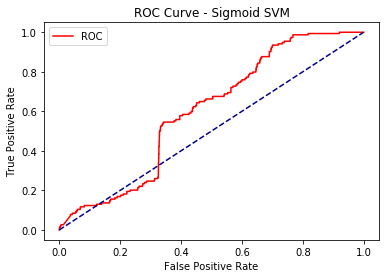

              Acuracy  Precision    Recall  F1-score    F-beta    TP      TN  \
Sigmoid SVM  0.564487   0.042081  0.603896   0.07868  0.164544  93.0  2730.0   

             ROC Curve  
Sigmoid SVM   0.583566  
Tot:5001 0:4847 1:154


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 3:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 4:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 5:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 6:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 7:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 8:
Tot:5000 0:4847 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 9:
best fold 9
Sigmoid SVM

              precision    recall  f1-score   support

           0       0.98      0.57      0.72      4846
           1       0.04      0.62      0.08       153

    accuracy                           0.57      4999
   macro avg       0.51      0.59      0.40      4999
weighted avg       0.95      0.57      0.70      4999

-------
Metrics
-------
Acurácia: 0.5689137827565514

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.04333941605839416
Precisão macro: 0.511338393458481
Precisão micro: 0.5689137827565514

Recall normal: 0.6209150326797386

Recall macro: 0.5940935047839468
Recall micro: 0.5689137827565514

F1-Score normal: 0.08102345415778252

F1-Score macro: 0.3997172673898805
F1-Score micro: 0.5689137827565514

Fbeta1 normal: 0.08102345415778252

Fbeta1 macro: 0.3997172673898805
Fbeta1 micro: 0.56891

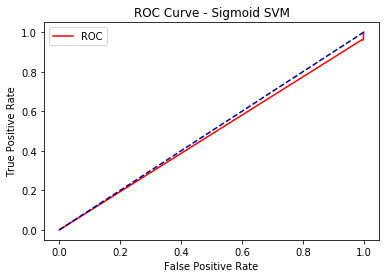

              Acuracy  Precision    Recall  F1-score    F-beta    TP      TN  \
Sigmoid SVM  0.568914   0.043339  0.620915  0.081023  0.169401  95.0  2749.0   

             ROC Curve  
Sigmoid SVM   0.594094  
Tot:4999 0:4846 1:153


/home/viniman/.local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


For fold 10:
best fold 10
Sigmoid SVM

              precision    recall  f1-score   support

           0       0.98      0.57      0.72      4846
           1       0.04      0.63      0.08       153

    accuracy                           0.57      4999
   macro avg       0.51      0.60      0.40      4999
weighted avg       0.95      0.57      0.70      4999

-------
Metrics
-------
Acurácia: 0.5687137427485497

------------
Micro: Calcule métricas globalmente, contando o total de tp, fn e fp.
Micro: Calcule métricas para cada classe e encontre sua média não ponderada.
------------

Precisão normal: 0.04373576309794989
Precisão macro: 0.5117038301937681
Precisão micro: 0.5687137427485497

Recall normal: 0.6274509803921569

Recall macro: 0.5971551228828305
Recall micro: 0.5687137427485497

F1-Score normal: 0.0817717206132879

F1-Score macro: 0.3999708276269054
F1-Score micro: 0.5687137427485497

Fbeta1 normal: 0.0817717206132879

Fbeta1 macro: 0.3999708276269054
Fbeta1 micro: 0.5687

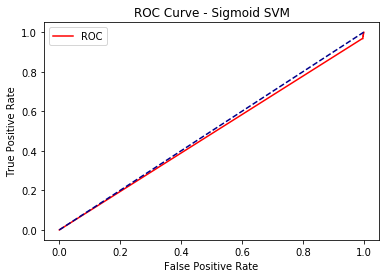

              Acuracy  Precision    Recall  F1-score    F-beta    TP      TN  \
Sigmoid SVM  0.568714   0.043736  0.627451  0.081772  0.171001  96.0  2747.0   

             ROC Curve  
Sigmoid SVM   0.597155  
Tot:4999 0:4846 1:153


TypeError: can only concatenate list (not "tuple") to list

In [39]:
clf = svm.SVC(kernel='sigmoid', probability=True) # Sigmoid Kernel
sampling = SMOTE()
result, results_folds, bestModel = cv(X, y, clf, 'Sigmoid SVM', sampling)
all_results = all_results.append(result)

In [ ]:
result

In [ ]:
results_folds

## Resultados Gerais

In [ ]:
all_results

In [ ]:
print(all_results.to_latex())

###### Análise Balanceamento

In [ ]:
print('Sample Confirmed:', len(X[y == 1]), '(%):', len(X[y == 1])/len(X))
print('Sample Unconfirmed:', len(X[y == 0]), '(%):', len(X[y == 0])/len(X))
print('Train Confirmed:', len(X_train[y_train == 1]), '(%):', len(X_train[y_train == 1])/len(X_train))
print('Train Unconfirmed:', len(X_train[y_train == 0]), '(%):', len(X_train[y_train == 0])/len(X_train))
print('Test Confirmed:', len(X_test[y_test == 1]), '(%):', len(X_test[y_test == 1])/len(X_test))
print('Test Unconfirmed:', len(X_test[y_test == 0]), '(%):', len(X_test[y_test == 0])/len(X_test))

# Others and Future Works

_______________

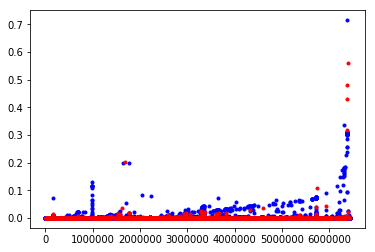

In [169]:
plt.plot(X.time_pending[y == 0], 'b.') # quando a transação não falha
plt.plot(X.time_pending[y == 1], 'r.') # quando a transação falha

# CrossValPredict

In [ ]:
_y, y_pred, model = crossValidationPredict(df)
print(y_pred.shape, _y.shape)
analysis(df, df[featuresColumns], _y, y_pred, 'Cross Val Predict - class_weight = True')

## Grid Decision Tree

In [ ]:
#df = dfRead.sample(1000000, random_state=234)

In [ ]:
#df[featuresColumns] = Normalizer().fit_transform(df[featuresColumns])

In [ ]:
print('Confirmed:', len(df[df.receipt_status == 1]), '(%):', len(df[df.receipt_status == 1])/len(df))
print('Unconfirmed:', len(df[df.receipt_status == 0]), '(%):', len(df[df.receipt_status == 0])/len(df))

In [ ]:
model = gridSearchDecisionTree(X_train, y_train) #crossValidationPredict(df, balancing=True)
#model = gridSearchDecisionTree(df[featuresColumns], df[targetColumn])

In [ ]:
y_predict = model.predict(X=X_test)

In [ ]:
analysis(df, X_test, y_test, y_pred, 'Grid Decisions Tree - Normalizer')

# SVM
___

In [ ]:
clf = svm.SVC(kernel='linear') # Linear Kernel
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
analysis(X_test, y_test, y_pred, 'Linear SVM')

In [ ]:
print(clf.n_support_)
print(clf.support_.shape)
print(clf.support_)
print(clf.support_vectors_.shape)
print(clf.support_vectors_)
print(clf.dual_coef_.shape)
print(clf.coef_.shape)
print(clf.dual_coef_)
print(clf.coef_)

In [ ]:
clf.decision_function(X_test)

In [ ]:
clf.get_params

In [ ]:
clf = svm.SVC(kernel='poly', degree=8) # Polynomial Kernel
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
analysis(X_test, y_test, y_pred, 'Polynomial SVM')

In [ ]:
clf = svm.SVC(kernel='rbf') # Gaussian Kernel - gamma=0.1
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
analysis(df, X_test, y_test, y_pred, 'Gaussian SVM')

In [ ]:
model = svm.SVC(kernel='sigmoid') # Sigmoid Kernel
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
analysis(X_test, y_test, y_pred, 'Sigmoid SVM')

In [ ]:
# Parameter Tuning using GridSearchCV
# Tuning Hyperparameters
# Kernel, Regularization, Gamma
# Grid Search
# Parameter Grid
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001, 0.00001, 10], 'kernel': ['sigmoid', 'rbf']}
 
# Make grid search classifier
clf_grid = GridSearchCV(svm.SVC(), param_grid, verbose=1)
 
# Train the classifier
clf_grid.fit(X_train, y_train)
 
# clf = grid.best_estimator_()
print("Best Parameters:\n", clf_grid.best_params_)
print("Best Estimators:\n", clf_grid.best_estimator_)

# View best hyperparameters
print('Best Penalty:', clf_grid.best_estimator_.get_params()['penalty'])
print('Best C:', clf_grid.best_estimator_.get_params()['C'])

# Regressão Logistica

In [ ]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
result = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # X[:2, :]
#print(clf.score(X_test, y_test))
analysis(df, X_test, y_test, y_pred, 'Logistic Regression')

# Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=100, random_state=2, max_depth=2)
clf.fit(X_train, y_train)
#print(X_train.columns)
#print(clf.feature_importances_)
y_pred = clf.predict(X_test)
analysis(X_test, y_test, y_pred, 'Random Florest')

In [ ]:
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

In [ ]:
ver a correlação entre features e importancia entre elas
fazer a parada de ir tirando features até encontrar a quantidade certa

# Verificar possíveis features em potenciais que podem ser 
#tiradas ou geradas a partir dos dados que já temos e dos dados dos blocos
# Dissertação do Saulo

SBRC

Sigcom dos chines
Caracteriza mas não vê os anomalos

Pegar artigo do saulo, e a minha abordagem é mais simples
abordagem inviezada
pode ta decorando, ou pode estar inviesando
a minha abordagem é mais justa e correta

cadeia de markov - artigo do saulo
aprendizado de maquina - dissertação



SBRC 
Introdução
principio meio e fim


metododologia
noção do que vc fez
processo de arvore de decisao
noção de arvore de decisao da metodologia
como sao meus dados
coleta, limpeza e processamento
porque fiz a limpeza, por isso e aquilo
fiz tecnica tecnica, usei tal coisa
quais sao os resultados
analise dos resultados
pra cada resultado, coloca a figura, eixo x e isso, y é isso
exemplo da figura, 50% tao fazendo isso 50 aquilo
resultado geral
essa figura mostra que a maioria dos usuarios tem valor baixo
de forma geral ela fala isso
esse ponto fala isso

ser burocratico no inicio
mostrar insight


- Pegar a melhor árvore e desenhar ela
- Ou seja, pegar os melhores parâmetros para desenhar a árvore
- Interpretar a árvore


# Reunião 29/10/2019

- Organizar processo
- Cross Validation, balanceamento de treino, modelos, svm, decision tree, random forest, regressão logistica
- Montar tabela com soluções dos modelos (acrescentar f-measure): automatizado
- Corrigir todo o processo
- Usar dataset da iris (sklearn.datasets.iris) - teste de sanidade
- Prever para o caso padrão
- Prever juntando os grupos (1,2:1 3:0 - 2,3:1 1:0, 1,3:1 2:0)
- Mostrar certo o que é o que, se 0 é a classe nao aceita, e 1 é a classe de aceitos (deixar explicito)
- Usar undersample, oversample e smote
- Criar um PDF com todos os resultados e enviar para o pessoal
- Cálculo dos folds: melhor com média, mediana e desvio padrão

- Ver coisas que o saulo pediu sobre o SVM:
- Valor de margem
- Peso componentes do vetor w
- Acurácia

In [ ]:
https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

In [ ]:
https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html

In [ ]:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

# Melhor árvore (qual score usar para decidir? AUC ROC?)
________

In [ ]:
X = dfNew[['gas', 'gas_price', 'gas_offered', 'time_pending']]
y = dfNew['receipt_status']
class_names = np.asarray(['unconfirmed', 'confirmed'])

model = tree.DecisionTreeClassifier()
results = cross_validate(model, X, y, cv=10, return_estimator=True)

print(results['test_score'])
print('Média test_score:', results['test_score'].mean())

iBest = count = 0
best = results['test_score'][0]
for i in results['test_score']:
    count+=1
    if(i > best):
        best = i
        iBest = count

bestEstimator = results['estimator'][0]
print(bestEstimator)
print(bestEstimator.feature_importances_)
print(bestEstimator.get_params(deep=True))

In [ ]:
#Get the best tree from cross validation
min_test = min(results['test_score'])
max_test = max(results['test_score'])
max_index = [i for i, j in enumerate(results["test_score"]) if j == max_test]

best_tree = results["estimator"][max_index[0]]
print(max_test, max_index)
print(results["estimator"][max_index[0]])

In [ ]:
#Get the best tree from cross validation
min_test = min(results['test_score'])
max_test = max(results['test_score'])
max_index = [i for i, j in enumerate(results["test_score"]) if j == max_test]

best_tree = results["estimator"][max_index[0]]
print(max_test, max_index)
print(results["estimator"][max_index[0]])

In [ ]:
#Show feature importances
best_tree.feature_importances_

# GridSearchCV
____
The GridSearchCV class in scikit-learn already does cross validation internally. You can pass any CV iterator as the cv argument of the constructor of GridSearchCV.

Demonstration of multi-metric evaluation on cross_val_score and GridSearchCV
Multiple metric parameter search can be done by setting the scoring parameter to a list of metric scorer names or a dict mapping the scorer names to the scorer callables.

The scores of all the scorers are available in the cv_results_ dict at keys ending in '_<scorer_name>' ('mean_test_precision', 'rank_test_precision', etc…)

The best_estimator_, best_index_, best_score_ and best_params_ correspond to the scorer (key) that is set to the refit attribute.

In [ ]:
# Author: Raghav RV <rvraghav93@gmail.com>
# License: BSD

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


#Running GridSearchCV using multiple evaluation metrics
# Load the dataset
df = dfNew
X = df[['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']]
y = df['receipt_status']
class_names = np.asarray(['unconfirmed', 'confirmed'])

# The scorers can be either be one of the predefined metric strings or a scorer
# callable, like the one returned by make_scorer
#scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}
scoring = {'AUC': 'roc_auc', 'Accuracy' : make_scorer(accuracy_score), 'Precion' : make_scorer(precision_score), 'Recall' : make_scorer(recall_score)}

# Setting refit='AUC', refits an estimator on the whole dataset with the
# parameter setting that has the best cross-validated AUC score.
# That estimator is made available at ``gs.best_estimator_`` along with
# parameters like ``gs.best_score_``, ``gs.best_params_`` and
# ``gs.best_index_``
gs = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid={'min_samples_split': range(2, 40, 2), 'class_weight': [None, 'balanced'],'min_impurity_decrease': [.01, .05,.1, .15, .2, .25, .3]}, # range(1, 20, 2)[2, 5, 10]
                  scoring=scoring, cv=3, refit='AUC', return_train_score=True)
gs.fit(X, y)
results = gs.cv_results_

print ('best estimator ----------', gs.best_estimator_, '\n\n')
print ('cv results ----------', gs.cv_results_, '\n\n')
print ('best score ----------', gs.best_score_, '\n\n')
print ('best params ----------', gs.best_params_, '\n\n')
print ('best index ----------', gs.best_index_, '\n\n')






#Plotting the result
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(0, 402)
ax.set_ylim(0.73, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_min_samples_split'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()





# get best decision tree
decisionTreeToGraph(gs, [featuresColumns], class_names=class_names, saveFileName='bestGridSearchDecisionTreeTests')

In [ ]:
# Number of random trials
NUM_TRIALS = 1

# Load the dataset
df = dfNew
X = df['value', 'gas', 'gas_price', 'gas_offered', 'time_pending']
y = df['receipt_status']
class_names = np.asarray(['unconfirmed', 'confirmed'])

# Set up possible values of parameters to optimize over
gridS_params = {'max_depth': [3, 4, 5, 6, 7, 8],
            'min_samples_split': [.01, .05,.1, .15, .2, .25, .3],
            'min_samples_leaf': [.01, .05,.1, .15, .2, .25, .3],
            'min_impurity_decrease': [.01, .05,.1, .15, .2, .25, .3],
            'class_weight': [None, 'balanced'],
            'max_leaf_nodes': [None, 4, 5, 6, 7, 8, 10, 15]}

p_grid = {'max_depth': [4, 10],
            'min_samples_split': [.1, .3],
            'min_samples_leaf': [.1, .3],
            'min_impurity_decrease': [.1, .3],
            'class_weight': ['balanced'],
            'max_leaf_nodes': [None, 10]}

p_grid2 = {'max_depth': [4, 10]
            }


# We will use a DecisionTreeClassifier
dTree = tree.DecisionTreeClassifier()

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):
    print('Trial num: ', i)

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    #inner_cv = KFold(n_splits=2, shuffle=True, random_state=i)
    #outer_cv = KFold(n_splits=2, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=dTree, param_grid=p_grid2, n_jobs=-1, cv=3, iid=False) #svv refit=True
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_
    
    print ('best estimator ----------', gs.best_estimator_, '\n\n')
    print ('cv results ----------', gs.cv_results_, '\n\n')
    print ('best score ----------', gs.best_score_, '\n\n')
    print ('best params ----------', gs.best_params_, '\n\n')
    print ('best index ----------', gs.best_index_, '\n\n')


    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X, y=y, cv=10)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()